### Imports

In [454]:
import pandas as pd
import numpy as np

import missingno as msno

import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.graph_objects as go

from scipy import stats
from scipy.stats import mannwhitneyu, shapiro
pd.set_option('display.max_columns', None)

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import warnings

### Data Loading

In [227]:
df_offers = pd.read_excel('../data_xlsx/df_offers.xlsx')
df_orders = pd.read_excel('../data_xlsx/df_orders.xlsx')

df_placements = pd.read_excel('../data_xlsx/df_placements.xlsx')
df_stats = pd.read_excel('../data_xlsx/df_stats.xlsx')

df_authors = pd.read_csv('../data_csv/df_authors (1).csv')

<Axes: >

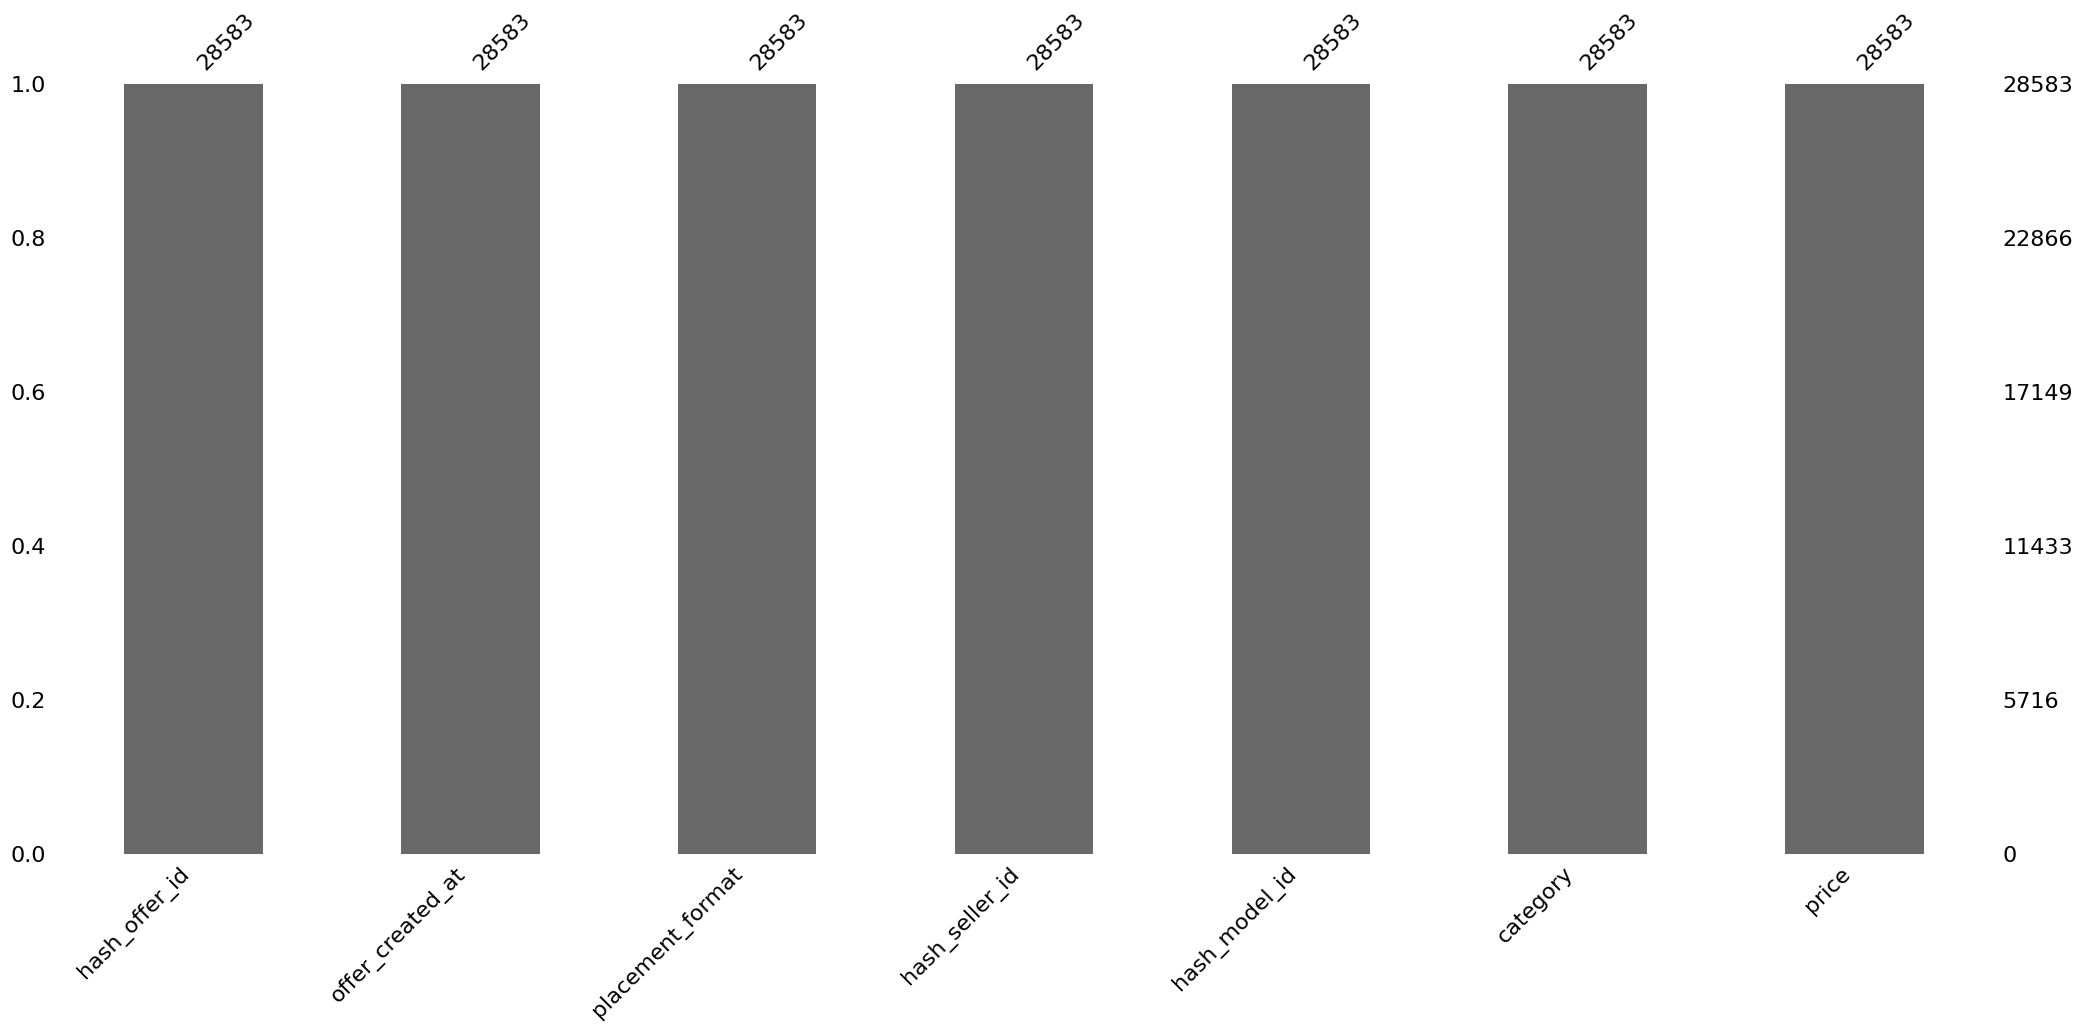

In [228]:
msno.bar(df_offers)

<Axes: >

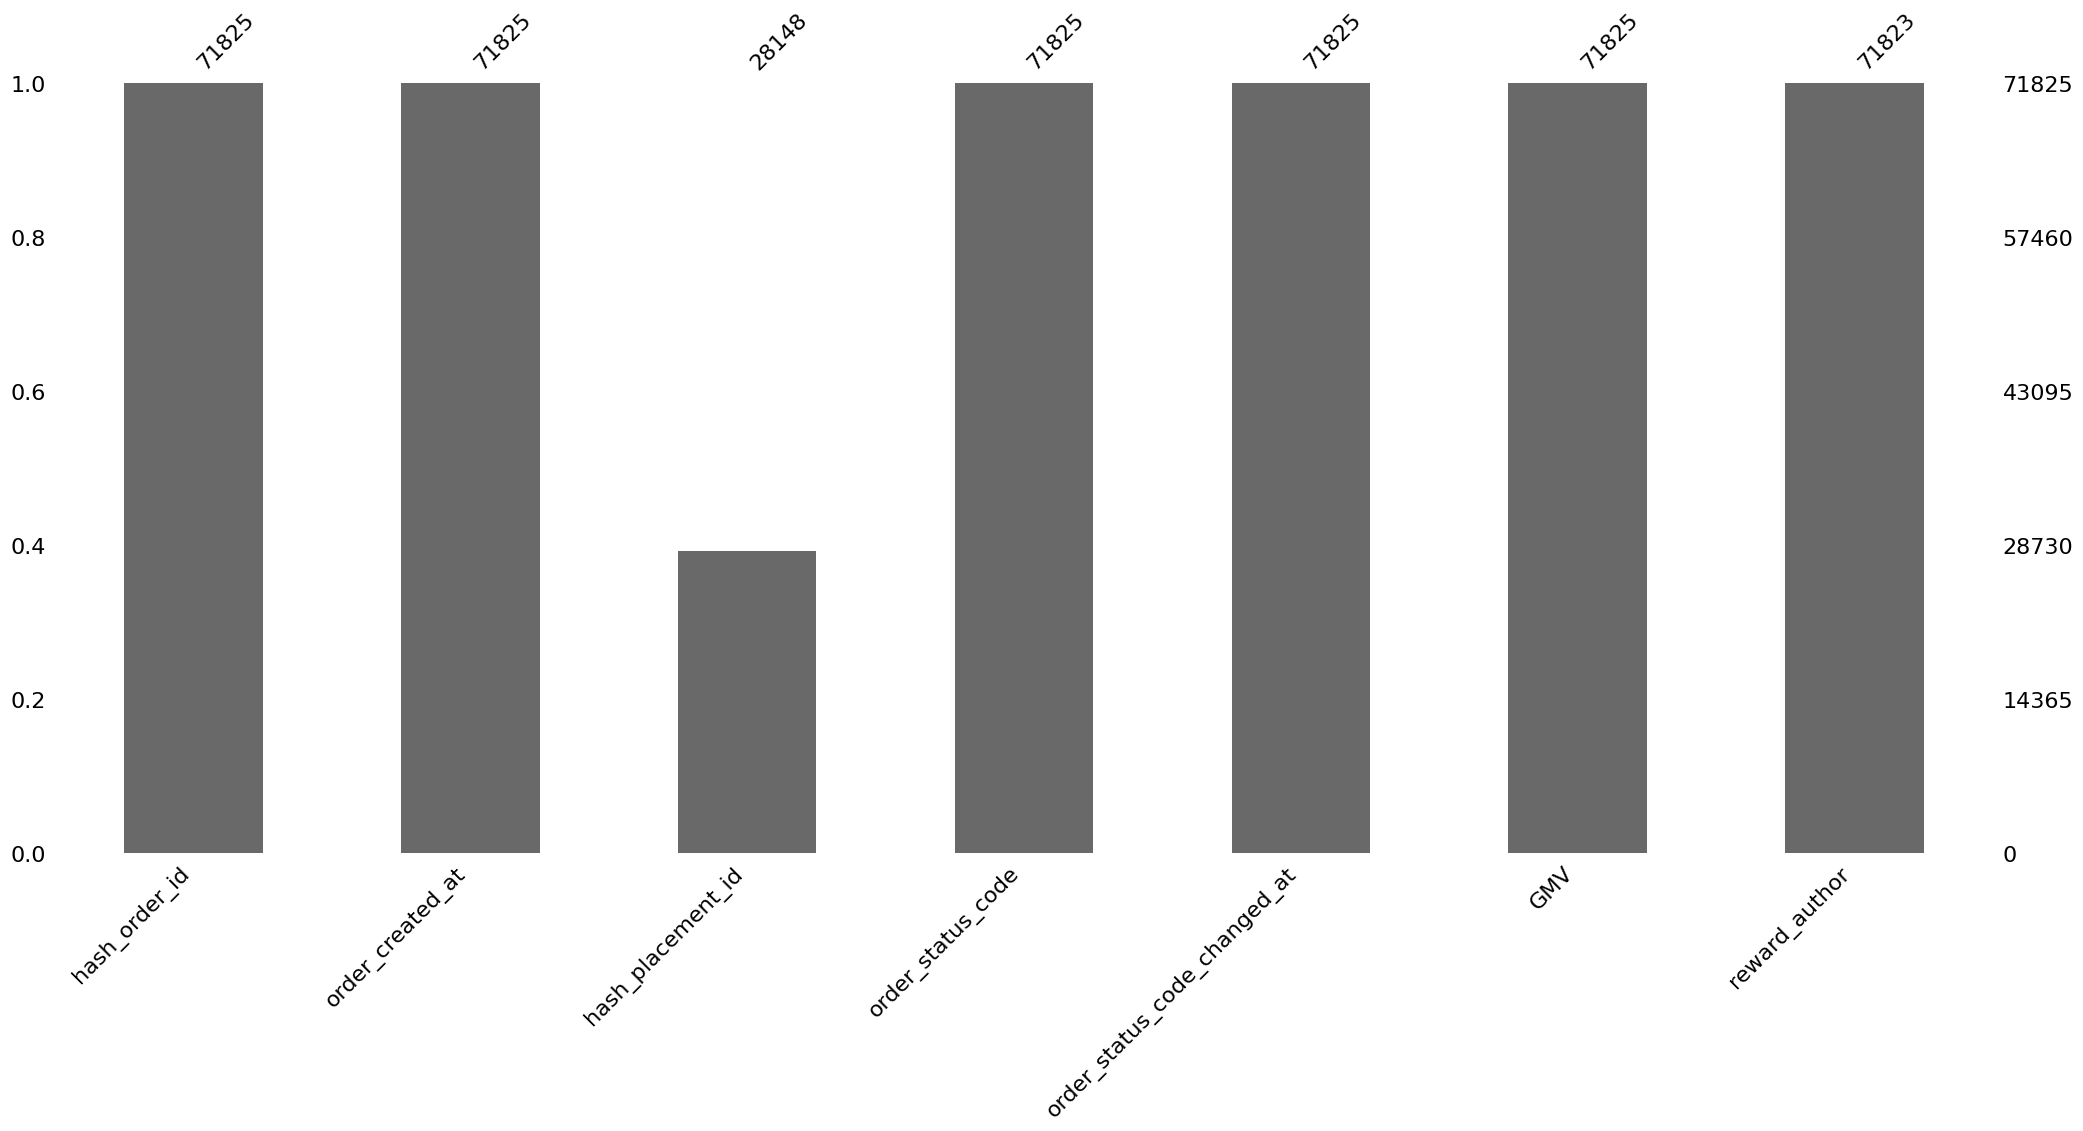

In [229]:
msno.bar(df_orders)

<Axes: >

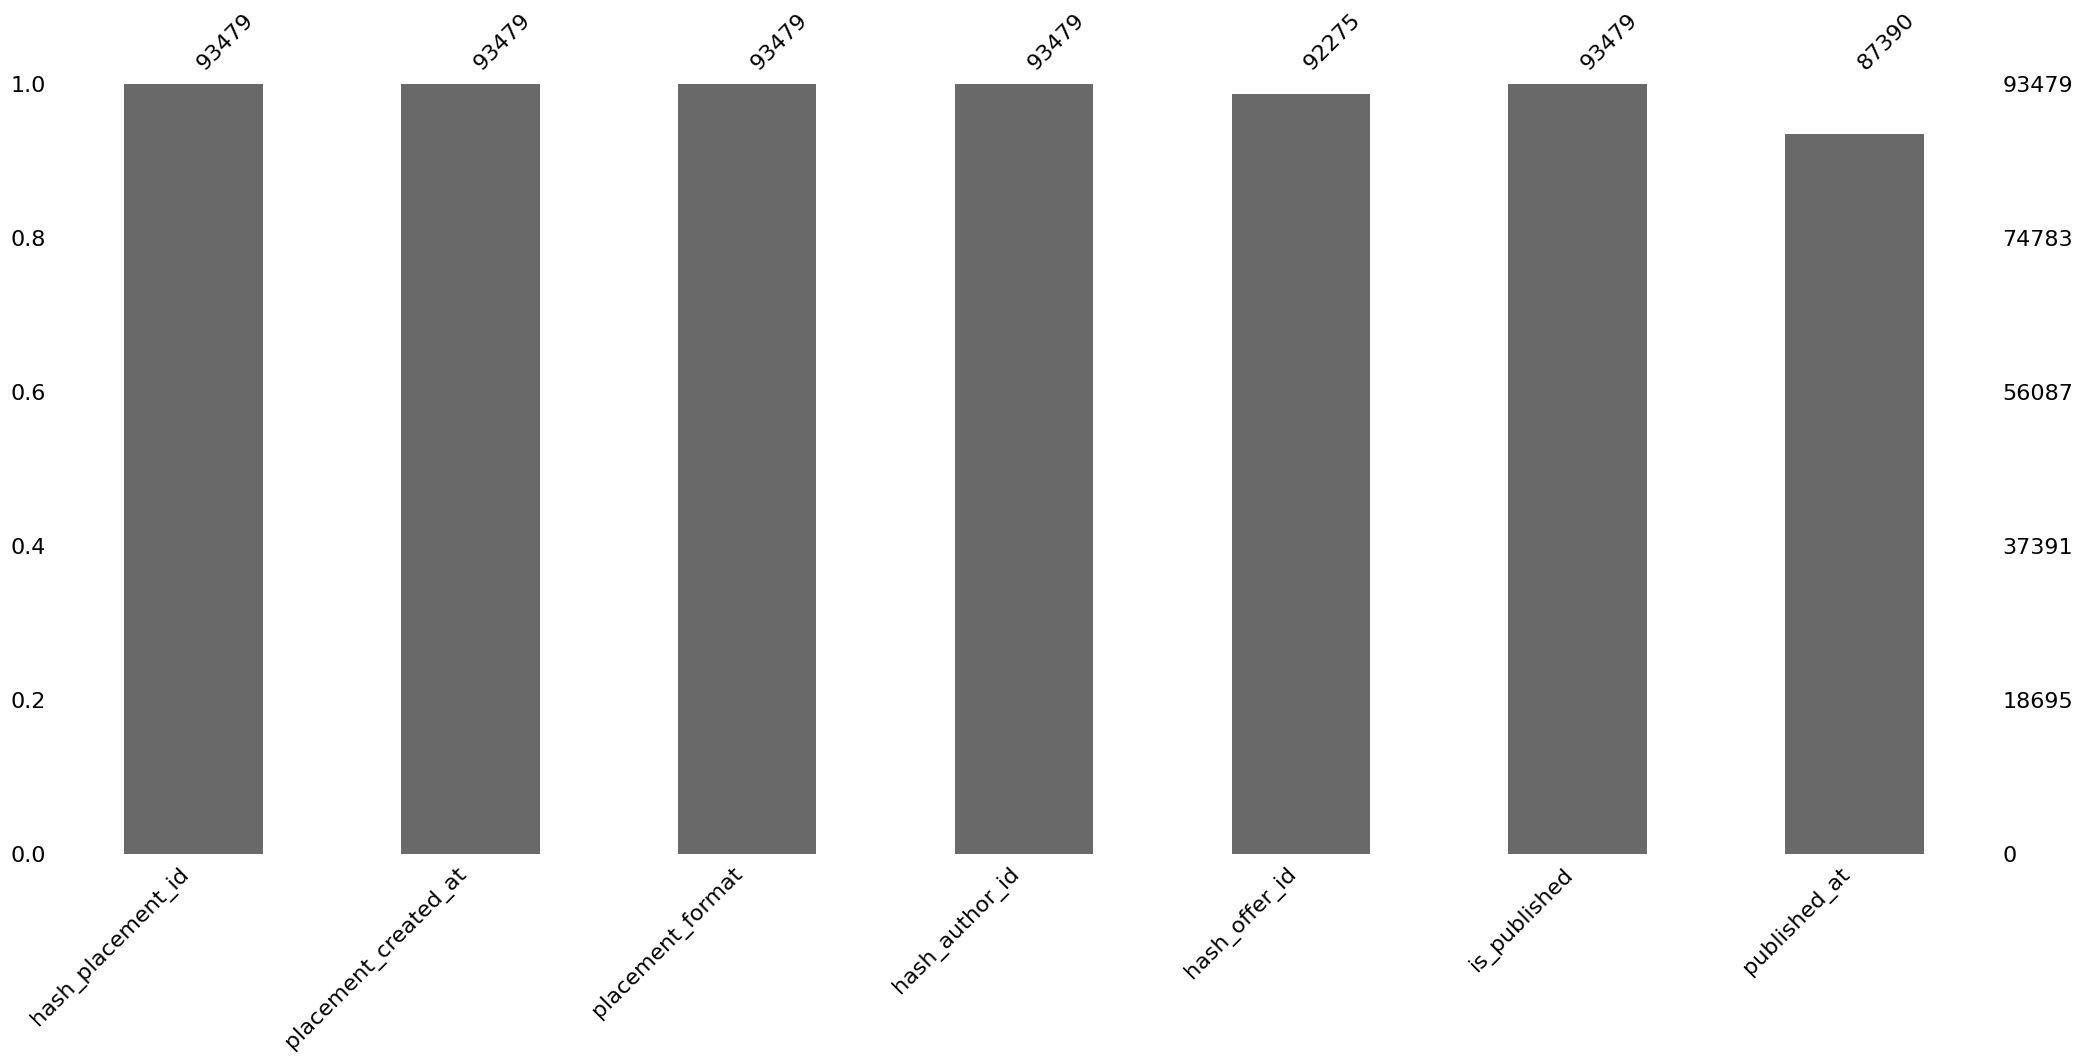

In [230]:
msno.bar(df_placements)

<Axes: >

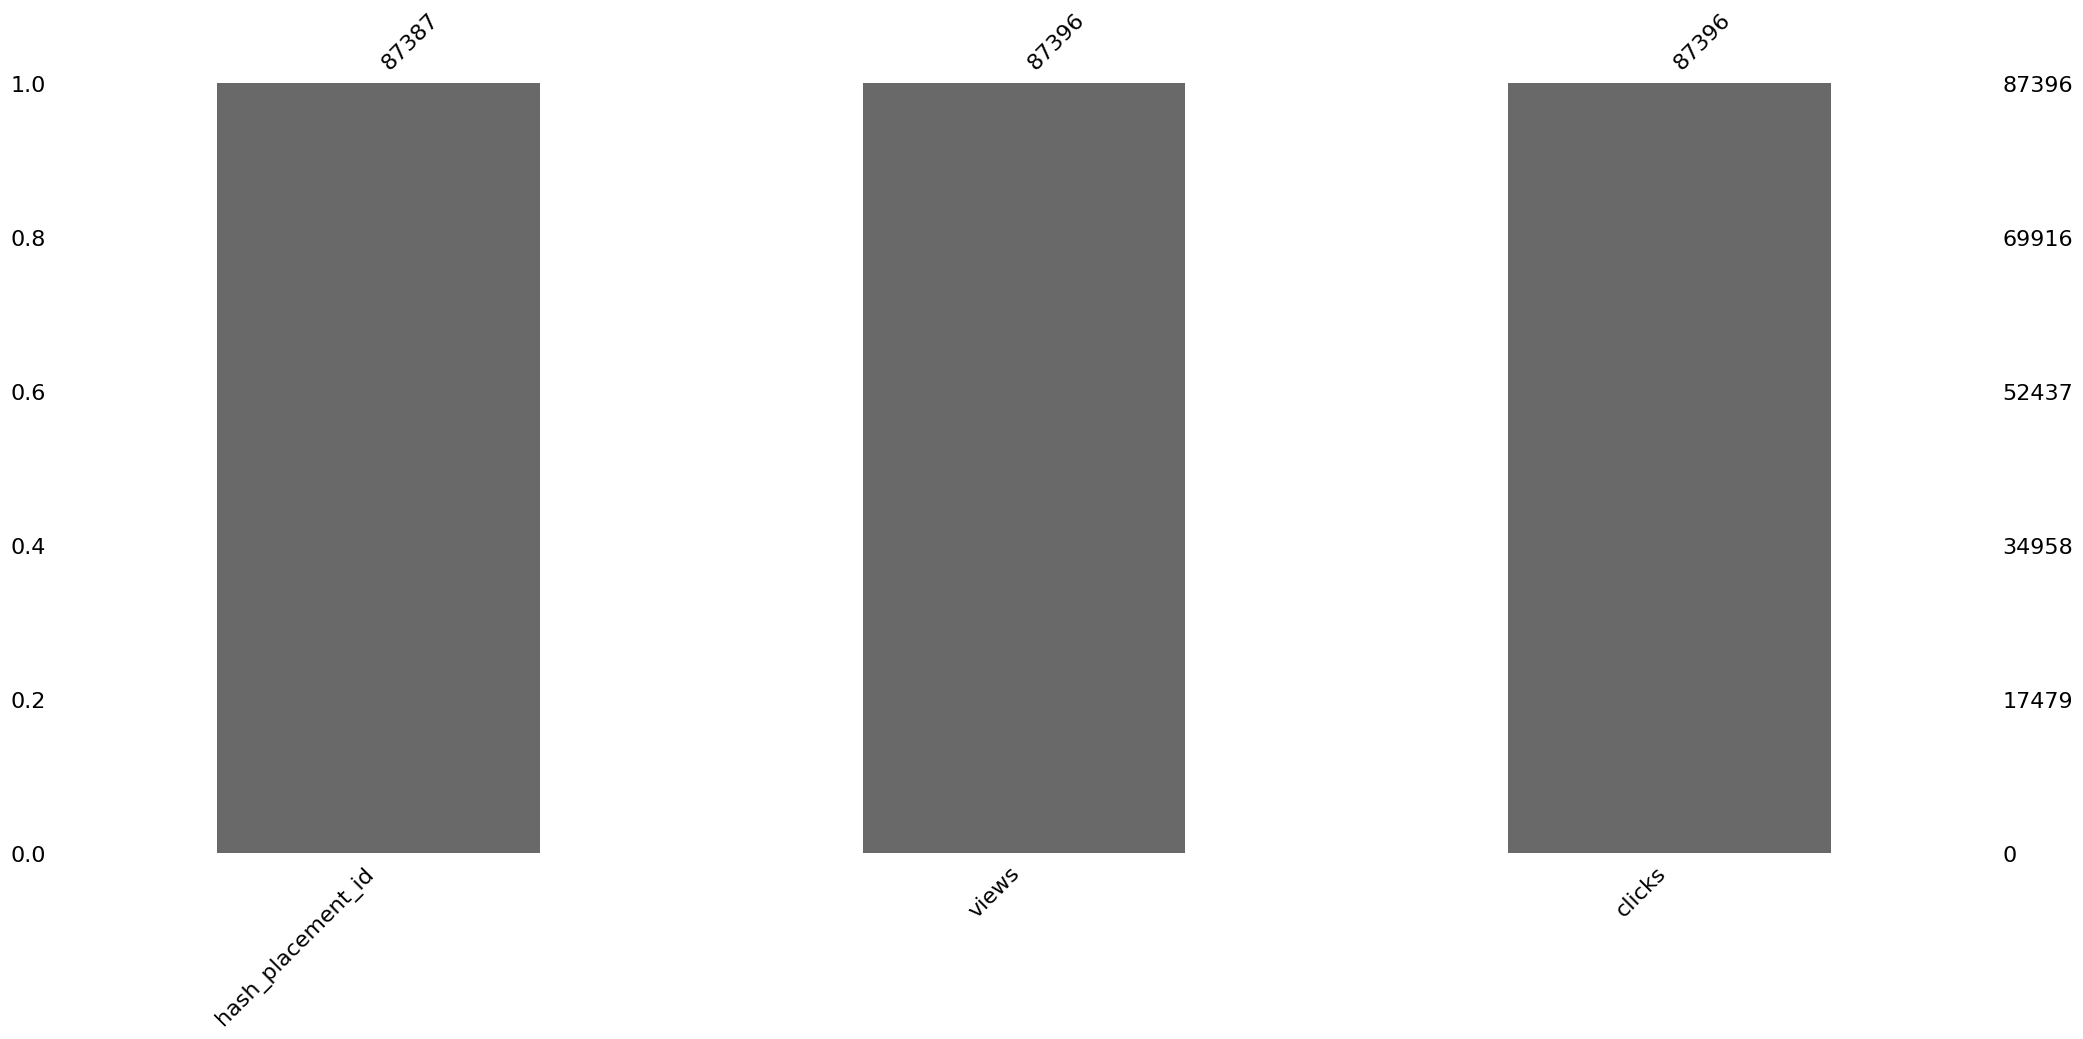

In [231]:
msno.bar(df_stats)

### Data Merging and Cleaning

In [232]:
df_placements_with_stats = pd.merge(df_placements, df_stats, on='hash_placement_id', how='inner')

In [233]:
df_placements_with_stats_and_category = pd.merge(df_placements_with_stats, df_offers, on='hash_offer_id', how='inner')

In [234]:
df_placements_with_stats_and_category['CR'] = df_placements_with_stats_and_category['clicks'] / df_placements_with_stats_and_category['views']

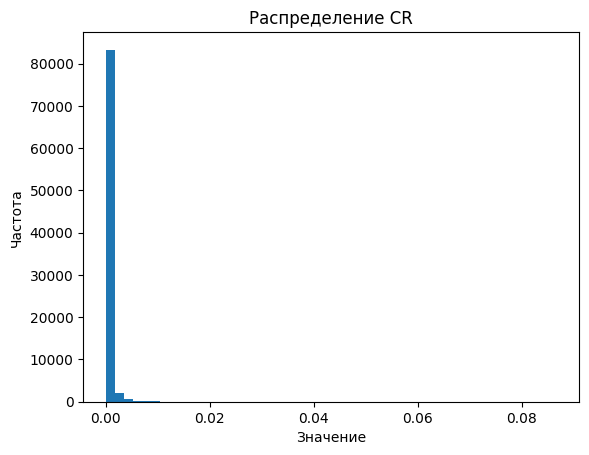

In [235]:
plt.hist(df_placements_with_stats_and_category['CR'], bins = 50)
plt.title('Распределение CR')
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.show();

In [236]:
data1 = df_placements_with_stats_and_category

In [237]:
fig = go.Figure()
fig.add_trace(go.Histogram(
    x=data1['views'],
    name='Распределение просмотров',
    opacity=0.7,
    marker_color='blue'
))

In [238]:
data2 = df_placements_with_stats_and_category.groupby('category').agg({"views": "sum", 
                                                                       "clicks": "sum"}).reset_index()
data2['CR'] = data2['clicks'] / data2['views'] * 100
data2 = data2.sort_values('views', ascending=False)
data2

,category,views,clicks,CR
2,Гардероб,733769082,169466,0.023095
4,Дом и дача,694260083,191235,0.027545
9,Спорт и отдых,416164814,96349,0.023152
6,Красота и здоровье,368841164,96618,0.026195
0,Бытовая техника,222245391,49853,0.022432
14,Электроника,147001948,44724,0.030424
3,Детские товары,126953048,34811,0.027420
12,Транспорт,90809896,14895,0.016402
13,Хобби и развлечения,79951104,40089,0.050142
7,Продукты питания,78678188,17327,0.022023


In [239]:
len(df_placements_with_stats_and_category)

86455

In [240]:
df_offers_and_orders = pd.merge(df_placements_with_stats_and_category, df_orders, on = 'hash_placement_id', how='inner')

In [241]:
published_mask = (df_offers_and_orders['reward_author'] > 0) | (df_offers_and_orders['is_published'] == True)

df_offers_and_orders_published = df_offers_and_orders[published_mask]
# будем считать, что если автор получил награду - то пост/шортс опубликован

In [242]:
df_placements_with_stats_and_category.columns.tolist()


['hash_placement_id',
 'placement_created_at',
 'placement_format_x',
 'hash_author_id',
 'hash_offer_id',
 'is_published',
 'published_at',
 'views',
 'clicks',
 'offer_created_at',
 'placement_format_y',
 'hash_seller_id',
 'hash_model_id',
 'category',
 'price',
 'CR']

### IQR views

In [ ]:
def iqr(data):

    data = np.array(data)
    data = data[~np.isnan(data)]
    
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    return {
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound
    }

(array([2.5283e+04, 1.3820e+03, 8.8200e+02, 9.2000e+01, 2.4000e+02,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 9.0000e+00]),
 array([2.20000000e+02, 1.28034790e+06, 2.56047580e+06, 3.84060370e+06,
        5.12073160e+06, 6.40085950e+06, 7.68098740e+06, 8.96111530e+06,
        1.02412432e+07, 1.15213711e+07, 1.28014990e+07]),
 <BarContainer object of 10 artists>)

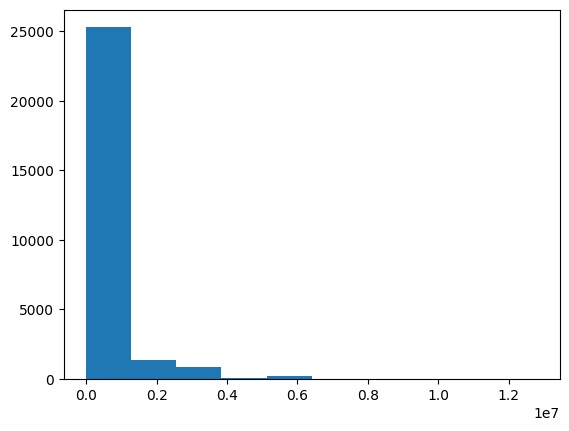

In [244]:
plt.hist(df_offers_and_orders_published['views'])

In [245]:
iqr(df_offers_and_orders_published['views'])

{'Q1': np.float64(41801.0),
 'Q3': np.float64(330758.0),
 'IQR': np.float64(288957.0),
 'lower_bound': np.float64(-391634.5),
 'upper_bound': np.float64(764193.5)}

In [246]:
result_v = iqr(df_offers_and_orders_published['views'])

df_offers_and_orders_v = df_offers_and_orders_published[df_offers_and_orders_published['views'] <= result_v['upper_bound']]
outliers = df_offers_and_orders_published[df_offers_and_orders_published['views'] > result_v['lower_bound']]

{'whiskers': [<matplotlib.lines.Line2D at 0x130136900>,
 'caps': [<matplotlib.lines.Line2D at 0x130136ba0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1301367b0>],
 'medians': [<matplotlib.lines.Line2D at 0x130136e40>],
 'fliers': [<matplotlib.lines.Line2D at 0x130136f90>],
 'means': []}

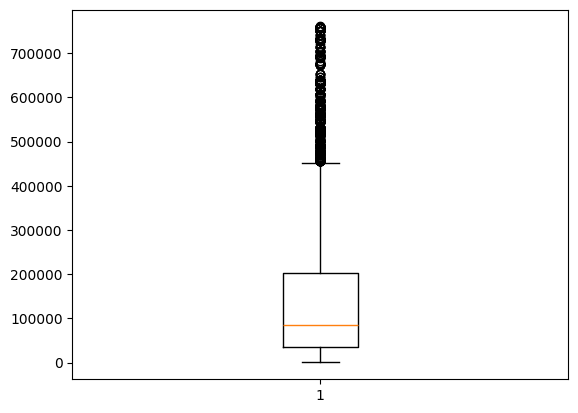

In [247]:
plt.boxplot(df_offers_and_orders_v['views'])

{'whiskers': [<matplotlib.lines.Line2D at 0x130122510>,
 'caps': [<matplotlib.lines.Line2D at 0x1301227b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1301223c0>],
 'medians': [<matplotlib.lines.Line2D at 0x130122a50>],
 'fliers': [<matplotlib.lines.Line2D at 0x130122ba0>],
 'means': []}

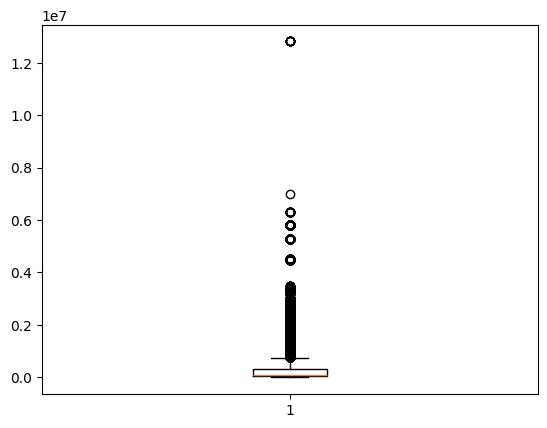

In [248]:
plt.boxplot(outliers['views'])

### Grouping by category

In [249]:
data2 = df_offers_and_orders_published.groupby('category').agg({'hash_placement_id': 'count',
                                                                'views': 'sum',
                                                                'clicks': 'sum'}).reset_index()

In [250]:
data2 = data2.sort_values('hash_placement_id', ascending = False)
data2['CR'] = data2['clicks'] / data2['views']

data2['views_per_placement'] = data2['views'] / data2['hash_placement_id']

In [251]:
data2

,category,hash_placement_id,views,clicks,CR,views_per_placement
4,Дом и дача,9450,3008670277,2304563,0.000766,3.183778e+05
6,Красота и здоровье,6206,3045459485,2396873,0.000787,4.907282e+05
2,Гардероб,4623,1250583176,2347600,0.001877,2.705133e+05
9,Спорт и отдых,1941,497355068,529473,0.001065,2.562365e+05
0,Бытовая техника,1074,422002240,332165,0.000787,3.929257e+05
7,Продукты питания,1008,929713104,383754,0.000413,9.223344e+05
13,Хобби и развлечения,823,69818568,149165,0.002136,8.483423e+04
11,Товары для животных,650,1445474153,460132,0.000318,2.223806e+06
3,Детские товары,578,277340331,151109,0.000545,4.798276e+05
14,Электроника,474,310986615,223730,0.000719,6.560899e+05


In [252]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=data2['category'],
    y=data2['views_per_placement'],
    marker_color='#0076fe',
    marker_line_color='#0076fe',
    marker_line_width=1.5,
    opacity=1
))

fig.update_layout(
    title='Среднее число просмотров на публикации для каждой категории',
    title_x=0.5,
    xaxis_title='Категории товаров',
    yaxis_title='',
    xaxis_tickangle=-45,
    height=600,
    showlegend=False,
    plot_bgcolor='#eaf2f8',
    paper_bgcolor='#eaf2f8'
)

In [253]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=data2['category'],
    y=data2['CR'],
    marker_color='#0076fe',
    marker_line_color='#0076fe',
    marker_line_width=1.5,
    opacity=1
))

fig.update_layout(
    title='Среднее число кликов на публикацию',
    title_x=0.5,
    xaxis_title='Категории товаров',
    yaxis_title='',
    xaxis_tickangle=-45,
    height=600,
    showlegend=False,
    plot_bgcolor='#eaf2f8',
    paper_bgcolor='#eaf2f8'
)

In [254]:
data2['category'].values.tolist()

['Дом и дача',
 'Красота и здоровье',
 'Гардероб',
 'Спорт и отдых',
 'Бытовая техника',
 'Продукты питания',
 'Хобби и развлечения',
 'Товары для животных',
 'Детские товары',
 'Электроника',
 'Канцелярские товары',
 'Транспорт',
 'Ремонт и строительство',
 'Все товары',
 'Товары для геймеров']

### Boxplots on price by categories

In [255]:
cat = ['Красота и здоровье',
        'Гардероб',
        'Дом и дача',
        'Спорт и отдых',
        'Детские товары',
        'Товары для животных',
        'Канцелярские товары',
        'Продукты питания',
        'Ремонт и строительство',
        'Все товары',
        'Бытовая техника',
        'Электроника',
        'Хобби и развлечения',
        'Транспорт',
        'Товары для геймеров']

df_offers_and_orders_published_iqr = pd.DataFrame()

for group in cat:
    group_data = df_offers_and_orders_published[df_offers_and_orders_published['category'] == group]

    result_gd = iqr(group_data['price'])
    
    group_data = group_data[(group_data['price'] <= result_gd['upper_bound']) & (group_data['price'] >= result_gd['lower_bound'])]
        
    df_offers_and_orders_published_iqr = pd.concat([df_offers_and_orders_published_iqr, group_data], ignore_index=True)
 
    

In [256]:
fig = go.Figure()

for group in cat:
    group_data = df_offers_and_orders_published_iqr[df_offers_and_orders_published_iqr['category'] == group]["price"]
    
    fig.add_trace(go.Box(
        y=group_data,
        name=str(group),
        boxpoints='outliers',
        marker_color='#0076fe',
        line_color="#0076fe",
        
    ))

fig.update_layout(
    title='Распределение стоимости опубликованных товаров',
    title_x=0.5,
    xaxis_title='Категории товаров',
    yaxis_title='Цена',
    xaxis_tickangle=-45,
    height=600,
    showlegend=True,
    plot_bgcolor='#eaf2f8',
    paper_bgcolor='#eaf2f8'
)

### Scatters

In [257]:
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=5, cols=3,
    subplot_titles=cat,
    vertical_spacing=0.08,
    horizontal_spacing=0.05
)

for i, group in enumerate(cat):
    group_data = df_offers_and_orders_published_iqr[df_offers_and_orders_published_iqr['category'] == group]

    if len(group_data) == 0:
        continue

    row = i // 3 + 1
    col = i % 3 + 1

    x_values = group_data['price'].values
    y_values = group_data['clicks'].values

    fig.add_trace(
        go.Scatter(
            x=x_values,
            y=y_values,
            mode='markers',
            name=group,
            marker=dict(
                color='deeppink',
                size=6,
                opacity=0.7,
                line=dict(
                    color='darkred',
                    width=0.5
                )
            ),
            showlegend=False
        ),
        row=row, col=col
    )
    
fig.update_layout(
    title_text='Price and clicks',
    title_x=0.5,
    height=1200,
    plot_bgcolor='rgba(0,0,0,0)'
)

fig.show()

### Offers, that was no published

In [258]:
offers_p_id = df_offers_and_orders_published['hash_offer_id'].values.tolist()

In [259]:
not_published_mask = (df_offers['hash_offer_id'].isin(offers_p_id))

df_offers_not_published = df_offers[~not_published_mask]
df_offers_published = df_offers[not_published_mask]

In [ ]:
print("Тест Шапиро-Уилка на нормальность:")
print(f"Опубликованные: p-value = {shapiro(df_offers_published['price'])[1]:.4f}")
print(f"Неопубликованные: p-value = {shapiro(df_offers_not_published['price'])[1]:.4f}")

Тест Шапиро-Уилка на нормальность:
Опубликованные: p-value = 0.0000
Неопубликованные: p-value = 0.0000


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5344.

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 23239.



In [261]:
u_stat, p_value_u = mannwhitneyu(df_offers_published['price'], df_offers_not_published['price'], alternative='greater')
print(f"U-тест Манна-Уитни: U = {u_stat:.4f}, p-value = {p_value_u:.4f}")

U-тест Манна-Уитни: U = 45274818.0000, p-value = 1.0000


In [262]:
print("Опубликованные offers:")
print(f"Количество: {len(df_offers_published['price'])}")
print(f"Средняя цена: {df_offers_published['price'].mean():.2f}")
print(f"Медиана: {df_offers_published['price'].median():.2f}")
print(f"Стандартное отклонение: {df_offers_published['price'].std():.2f}")

print("\nНеопубликованные offers:")
print(f"Количество: {len(df_offers_not_published['price'])}")
print(f"Средняя цена: {df_offers_not_published['price'].mean():.2f}")
print(f"Медиана: {df_offers_not_published['price'].median():.2f}")
print(f"Стандартное отклонение: {df_offers_not_published['price'].std():.2f}")

Опубликованные offers:
Количество: 5344
Средняя цена: 31367.19
Медиана: 4778.00
Стандартное отклонение: 210348.67

Неопубликованные offers:
Количество: 23239
Средняя цена: 78836.83
Медиана: 7607.00
Стандартное отклонение: 362282.98


### Bootstrap and XGboost

In [ ]:
def bootstrap_median(data, n_bootstrap=10000):
    
    n = len(data)
    boot_medians = []
    
    for _ in range(n_bootstrap):
        
        bootstrap_sample = np.random.choice(data, size=n, replace=True)
        boot_medians.append(np.median(bootstrap_sample))
    
    return np.percentile(boot_medians, [2.5, 97.5])

In [264]:
ci_median_published = bootstrap_median(df_offers_published['price'])
ci_median_not_published = bootstrap_median(df_offers_not_published['price'])

print("Bootstrap 95% доверительные интервалы для медиан:")
print(f"Опубликованные: {ci_median_published[0]:.2f} - {ci_median_published[1]:.2f}")
print(f"Неопубликованные: {ci_median_not_published[0]:.2f} - {ci_median_not_published[1]:.2f}")

if ci_median_published[1] < ci_median_not_published[0] or ci_median_not_published[1] < ci_median_published[0]:
    print("Доверительные интервалы не перекрываются - различия статистически значимы")
else:
    print("Доверительные интервалы перекрываются - различия могут быть не значимы")

Bootstrap 95% доверительные интервалы для медиан:
Опубликованные: 4563.00 - 5037.00
Неопубликованные: 7529.00 - 7710.00
Доверительные интервалы не перекрываются - различия статистически значимы


In [ ]:
df_placements_csv = pd.read_csv('../data_csv/df_placements.csv', sep=';')

df_offers_csv = pd.read_csv('../data_csv/df_offers.csv', sep=';')

df_stats_csv = pd.read_csv('../data_csv/df_stats.csv', sep=';')

print("Starting feature engineering...")

data = pd.merge(df_stats_csv, df_placements_csv, on='hash_placement_id', how='left')
data = pd.merge(data, df_offers_csv, on='hash_offer_id', how='left')

data['views'] = data['views'].apply(lambda x: eval(x)[0])
data['clicks'] = data['clicks'].apply(lambda x: eval(x)[0])

data['price'].fillna('0,0', inplace=True)
data['price'] = data['price'].apply(lambda x: eval(str(x))[0])

data['placement_format_x'] = data['placement_format_x'].astype('category')
data['hash_placement_id'] = data['hash_placement_id'].astype('category')
data['placement_created_at'] = data['placement_created_at'].astype('category')
data['published_at'] = data['published_at'].astype('category')
data['offer_created_at'] = data['offer_created_at'].astype('category')

data['ctr'] = data['clicks'] / data['views']

author_stats = data.groupby('hash_author_id').agg(
    author_avg_ctr=('ctr', 'mean'),
    author_placement_count=('hash_offer_id', 'count')
).reset_index()
data = pd.merge(data, author_stats, on='hash_author_id', how='left')

offer_stats = data.groupby('hash_offer_id').agg(
    offer_avg_ctr=('ctr', 'mean'),
    offer_placement_count=('hash_author_id', 'count')
).reset_index()
data = pd.merge(data, offer_stats, on='hash_offer_id', how='left')

author_category_stats = data.groupby(['hash_author_id', 'category']).agg(
    author_category_avg_ctr=('ctr', 'mean')
).reset_index()
data = pd.merge(data, author_category_stats, on=['hash_author_id', 'category'], how='left')

data = pd.get_dummies(data, columns=['placement_format_x',
                                     'category',
                                     'is_published',
                                     'hash_seller_id',
                                     'hash_model_id'])

data = data.sample(n=5000)

print("Feature engineering complete. Final data shape:", data.shape)

print("Training the XGBoost model...")

features = [col for col in data.columns if col not in ['hash_author_id', 'hash_offer_id', 'clicks', 'views', 'ctr']]
X = data[features]
y = data['ctr']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    enable_categorical = True,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
print('Training completed!')

Starting feature engineering...
Feature engineering complete. Final data shape: (5000, 54617)
Training the XGBoost model...
Training completed!


In [266]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"\nModel training complete. Test Set RMSE: {rmse:.6f}")


Model training complete. Test Set RMSE: 0.000633


### Authors

In [697]:
df_autors_placements_stats = pd.merge(df_authors, 
                                      df_placements_with_stats_and_category, 
                                      on = 'hash_author_id', 
                                      how = 'inner' )

In [268]:
df_autors_placements_stats['segment_code'].value_counts()

segment_code
2    61813
3    10802
4     9347
1     4422
6       71
Name: count, dtype: int64

#### Categories of authors

In [269]:
df_cat = df_autors_placements_stats.groupby('category_x').agg({'is_published': 'sum',
                                                               'size': 'sum',
                                                               'posts_30d': 'sum',
                                                               'posts_views_30d': 'sum',
                                                               "posts_reach_30d": 'sum',
                                                               'posts_likes_30d': 'sum',
                                                               "posts_comments_30d": 'sum',
                                                               'posts_reposts_30d': 'sum',
                                                               'clips_30d': 'sum',
                                                               'clips_views_30d': 'sum',
                                                               "clips_reach_30d": 'sum',
                                                               'clips_likes_30d': 'sum',
                                                               "clips_comments_30d": 'sum',
                                                               'clips_reposts_30d': 'sum',
                                                               'price': 'sum'}).reset_index()
df_cat.rename({"is_published": 'number_of_placements'}, axis=1, inplace = True)

In [270]:
df_cat['placements_30d'] = df_cat['posts_30d'] + df_cat['clips_30d']
df_cat['views_30d'] = df_cat['posts_views_30d'] + df_cat['clips_views_30d']
df_cat['likes_30d'] = df_cat['posts_likes_30d'] + df_cat['clips_likes_30d']
df_cat['comments_30d'] = df_cat['posts_comments_30d'] + df_cat['clips_comments_30d']
df_cat['reposts_30d'] = df_cat['posts_reposts_30d'] + df_cat['clips_reposts_30d']
df_cat['reach_30d'] = df_cat['posts_reach_30d'] + df_cat['clips_reach_30d']

df_cat['views/placements'] = df_cat['views_30d'] / df_cat['placements_30d']
df_cat['likes/placements'] = df_cat['likes_30d'] / df_cat['placements_30d']
df_cat['comments/placements'] = df_cat['comments_30d'] / df_cat['placements_30d']
df_cat['reposts/placements'] = df_cat['reposts_30d'] / df_cat['placements_30d']
df_cat['reach/placements'] = df_cat['reach_30d'] / df_cat['placements_30d']

In [271]:
df_cat = df_cat.sort_values('likes/placements', ascending=False)

In [272]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=df_cat['category_x'],
    y=df_cat['likes/placements'],
    marker_color='#0076fe',
    marker_line_color='#0076fe',
    marker_line_width=2,
    opacity=1
))

fig.update_layout(
    title='Среднее число лайков на публикацию',
    title_x=0.5,
    xaxis_title='Темы блогов',
    yaxis_title='',
    xaxis_tickangle=-45,
    height=600,
    showlegend=False,
    plot_bgcolor='#eaf2f8',
    paper_bgcolor='#eaf2f8'
)

In [273]:
a = list(df_cat['category_x'].values.tolist())
a

['ANIMALS',
 'COMPANY_CELEBRITY',
 'COMPANY_MASS_MEDIA',
 'BUSINESS',
 'COMMUNITY',
 'COMPANY_CULTURE',
 'MUSIC',
 'HEALTH_BEAUTY',
 'CULTURE_SOCIETY',
 'COMPANY_SPORT',
 'TOURISM',
 'EDUCATION',
 'MEDICINE',
 'ENTERTAINMENT',
 'HOUSE_REPAIR',
 'COMPANY_ENTERTAINMENT',
 'SPORT',
 'FOOD_COOKING',
 'FAMILY',
 'COMPANY_RESTAURANT',
 'AUTOMOTO',
 'COMPANY_PROF_SERVICES',
 'CITIES',
 'COMPANY_ANIMALS',
 'COMPANY_PURCHASES',
 'COMPANY_EDUCATION',
 'COMPANY_AUTO',
 'HOME_SEARCH',
 'COMPUTER_IT',
 'JOB',
 'COMPANY_HEALTH_BEAUTY',
 'COMPANY_SERVICE',
 'COMPANY_SOCIETY',
 'COMPANY_TOURISM',
 'FINANCE',
 'COMPANY_INTERNET',
 'CLASSIFIED']

#### Exact authors

In [710]:
df_authors_s = df_authors[df_authors['hash_author_id'].isin(df_placements_with_stats_and_category['hash_author_id'].values.tolist())]

In [711]:
df_authors_s['posts_eng_30d'] = (df_authors_s['posts_likes_30d'] + 
                                 df_authors_s['posts_reposts_30d'] +
                                 df_authors_s['posts_comments_30d']) / df_authors_s['posts_reach_30d']

df_authors_s['clips_eng_30d'] = (df_authors_s['clips_likes_30d'] + 
                                 df_authors_s['clips_reposts_30d'] +
                                 df_authors_s['clips_comments_30d']) / df_authors_s['clips_reach_30d']

df_authors_s['posts_avg_eng_30d'] = df_authors_s['posts_eng_30d'] / df_authors_s['posts_30d']
df_authors_s['clips_avg_eng_30d'] = df_authors_s['clips_eng_30d'] / df_authors_s['clips_30d']

Нужно оценить частоту публикаций блоггера. Введем пороговые значения:

- Pl_post_min = 4 (одна публикация в неделю)
- Pl_post_max = 30 (1 публикация в день)

Freq_factor = min(1, max(0, (posts_30d - Pl_min)/(Pl_max - Pl_min) ) )

In [712]:
df_authors_s['posts_freqfact_30d'] = df_authors_s['posts_freqfact_30d'] = ((df_authors_s['posts_30d'] - 4) / 26).clip(lower=0, upper=100)



df_authors_s['clips_freqfact_30d'] = df_authors_s['posts_freqfact_30d'] = ((df_authors_s['clips_30d'] - 4) / 26).clip(lower=0, upper=100)

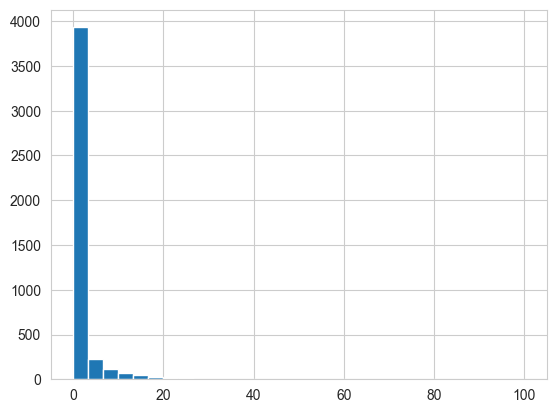

In [713]:
plt.hist(df_authors_s['posts_freqfact_30d'], bins=30);

In [714]:
df_authors_s['score_posts'] = df_authors_s['posts_freqfact_30d'] * df_authors_s['posts_avg_eng_30d'] * 100

df_authors_s['score_clips'] = df_authors_s['clips_freqfact_30d'] * df_authors_s['clips_avg_eng_30d'] * 100


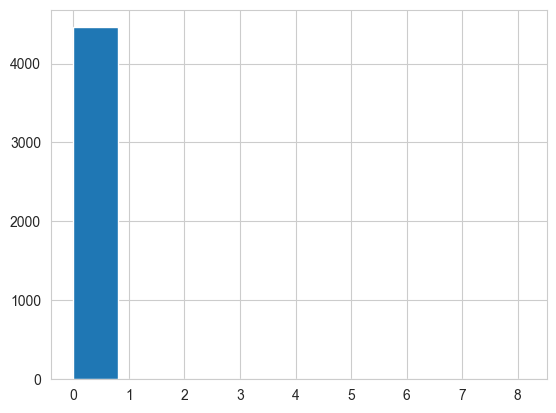

In [715]:
plt.hist(df_authors_s['score_posts']);

In [716]:
result_sc_p = iqr(df_authors_s['score_posts'])

df_authors_1 = df_authors_s[(df_authors_s['score_posts'] >= result_sc_p['lower_bound']) &
                              (df_authors_s['score_posts'] <= result_sc_p['upper_bound'])]

result_sc_c = iqr(df_authors_1['score_clips'])

df_authors_2 = df_authors_1[(df_authors_1['score_clips'] >= result_sc_c['lower_bound']) &
                                (df_authors_1['score_clips'] <= result_sc_c['upper_bound'])]
df_authors_2

,hash_author_id,segment_code,size,category,original,quality,expert,posts_30d,posts_views_30d,posts_reach_30d,posts_likes_30d,posts_comments_30d,posts_reposts_30d,clips_30d,clips_views_30d,clips_reach_30d,clips_likes_30d,clips_comments_30d,clips_reposts_30d,posts_eng_30d,clips_eng_30d,posts_avg_eng_30d,clips_avg_eng_30d,posts_freqfact_30d,clips_freqfact_30d,score_posts,score_clips
1,D4735E3A265E16EEE03F59718B9B5D03019C07D8B6C51F...,2,40895.0,COMMUNITY,aggregator,like,pugc,444.0,1481121.0,910920.0,50799.0,1880.0,1818.0,2.0,986.0,1045.0,3.0,0.0,0.0,0.059826,0.002871,0.000135,0.001435,0.000000,0.000000,0.000000,0.000000
2,4E07408562BEDB8B60CE05C1DECFE3AD16B72230967DE0...,2,228547.0,SPORT,aggregator,like,pugc,46.0,2843760.0,1761202.0,19563.0,934.0,422.0,18.0,479546.0,451188.0,6909.0,70.0,0.0,0.011878,0.015468,0.000258,0.000859,0.538462,0.538462,0.013904,0.046272
9,4A44DC15364204A80FE80E9039455CC1608281820FE2B2...,2,2710557.0,TOURISM,aggregator,like,pugc,450.0,63418997.0,43004040.0,551625.0,0.0,90810.0,28.0,1519954.0,1461814.0,23649.0,105.0,2.0,0.014939,0.016251,0.000033,0.000580,0.923077,0.923077,0.003064,0.053575
15,B17EF6D19C7A5B1EE83B907C595526DCB1EB06DB8227D6...,2,100700.0,COMPUTER_IT,aggregator,like,pugc,1086.0,6486002.0,3626326.0,25545.0,4906.0,3672.0,114.0,525706.0,436376.0,5562.0,180.0,0.0,0.009410,0.013158,0.000009,0.000115,4.230769,4.230769,0.003666,0.048833
35,76A50887D8F1C2E9301755428990AD81479EE21C25B432...,2,37915.0,CULTURE_SOCIETY,aggregator,like,pugc,432.0,416681.0,256097.0,2643.0,426.0,56.0,2.0,146.0,151.0,12.0,0.0,0.0,0.012202,0.079470,0.000028,0.039735,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5382,08B25A1FB4A58B22867BB84357D0368B782EBCF3DCF263...,2,19392.0,TOURISM,creator,like,pugc,108.0,1755764.0,1226102.0,28998.0,579.0,1850.0,6.0,10841.0,10091.0,348.0,8.0,2.0,0.025632,0.035477,0.000237,0.005913,0.076923,0.076923,0.001826,0.045484
5383,24975A89CBBA02CB0B417BA53AA3C8BCC3E7C556AB5927...,2,2117.0,FOOD_COOKING,aggregator,like,pugc,396.0,62455.0,41762.0,990.0,28.0,78.0,2.0,2.0,3.0,0.0,0.0,0.0,0.026244,0.000000,0.000066,0.000000,0.000000,0.000000,0.000000,0.000000
5389,1DB01826CF7FAF93BBEF9D581279E569C1192CDF5328E5...,2,30805.0,HEALTH_BEAUTY,aggregator,like,pugc,362.0,5100943.0,3387658.0,17256.0,370.0,8850.0,236.0,10061556.0,9698224.0,81030.0,346.0,57.0,0.007815,0.008397,0.000022,0.000036,8.923077,8.923077,0.019265,0.031748
5394,E3FF67A034BE1F249CAAB8A72F61E8AD2A64E417B5CE6E...,2,2798.0,FAMILY,creator,superlike,pugc,20.0,24458.0,14950.0,84.0,0.0,45.0,4.0,3252.0,2626.0,18.0,2.0,0.0,0.008629,0.007616,0.000431,0.001904,0.000000,0.000000,0.000000,0.000000


(array([918., 180., 113.,  96.,  70.,  57.,  55.,  49.,  36.,  39.]),
 array([0.        , 0.00244969, 0.00489938, 0.00734908, 0.00979877,
        0.01224846, 0.01469815, 0.01714784, 0.01959754, 0.02204723,
        0.02449692]),
 <BarContainer object of 10 artists>)

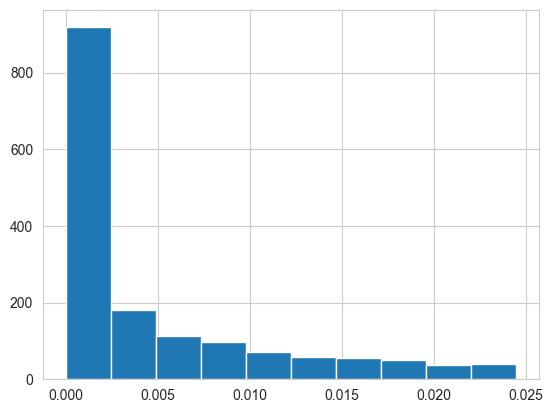

In [717]:
plt.hist(df_authors_2['score_posts'])

In [718]:
fig = go.Figure()

fig.add_trace(go.Box(
    y=df_authors_2['score_posts'],
    name='Посты',
    boxpoints='outliers',
    marker_color='#0076fe',
    line_color='#0076fe', 
    ))

fig.add_trace(go.Box(
    y=df_authors_2['score_clips'],
    name='Клипы',
    boxpoints='outliers',
    marker_color='#0076fe',
    line_color='#0076fe', 
    ))

fig.update_layout(
    title='Оценка блогера',
    title_x=0.5,
    xaxis_title='',
    yaxis_title='',
    xaxis_tickangle=0,
    height=600,
    showlegend=False,
    plot_bgcolor='#eaf2f8',
    paper_bgcolor='#eaf2f8'
)

In [719]:
ci_median_posts = bootstrap_median(df_authors_2['score_posts'])
ci_median_clips = bootstrap_median(df_authors_2['score_clips'])

print("Bootstrap 95% доверительные интервалы для медиан:")
print(f"Посты: {ci_median_posts[0]:.10f} - {ci_median_posts[1]:.10f}")
print(f"Клипы: {ci_median_clips[0]:.10f} - {ci_median_clips[1]:.10f}")

if ci_median_posts[1] < ci_median_clips[0] or ci_median_clips[1] < ci_median_posts[0]:
    print("Доверительные интервалы не перекрываются - различия статистически значимы")
else:
    print("Доверительные интервалы перекрываются - различия могут быть не значимы")

Bootstrap 95% доверительные интервалы для медиан:
Посты: 0.0011791531 - 0.0018076272
Клипы: 0.0079291923 - 0.0114706674
Доверительные интервалы не перекрываются - различия статистически значимы


In [720]:
df_authors_2

,hash_author_id,segment_code,size,category,original,quality,expert,posts_30d,posts_views_30d,posts_reach_30d,posts_likes_30d,posts_comments_30d,posts_reposts_30d,clips_30d,clips_views_30d,clips_reach_30d,clips_likes_30d,clips_comments_30d,clips_reposts_30d,posts_eng_30d,clips_eng_30d,posts_avg_eng_30d,clips_avg_eng_30d,posts_freqfact_30d,clips_freqfact_30d,score_posts,score_clips
1,D4735E3A265E16EEE03F59718B9B5D03019C07D8B6C51F...,2,40895.0,COMMUNITY,aggregator,like,pugc,444.0,1481121.0,910920.0,50799.0,1880.0,1818.0,2.0,986.0,1045.0,3.0,0.0,0.0,0.059826,0.002871,0.000135,0.001435,0.000000,0.000000,0.000000,0.000000
2,4E07408562BEDB8B60CE05C1DECFE3AD16B72230967DE0...,2,228547.0,SPORT,aggregator,like,pugc,46.0,2843760.0,1761202.0,19563.0,934.0,422.0,18.0,479546.0,451188.0,6909.0,70.0,0.0,0.011878,0.015468,0.000258,0.000859,0.538462,0.538462,0.013904,0.046272
9,4A44DC15364204A80FE80E9039455CC1608281820FE2B2...,2,2710557.0,TOURISM,aggregator,like,pugc,450.0,63418997.0,43004040.0,551625.0,0.0,90810.0,28.0,1519954.0,1461814.0,23649.0,105.0,2.0,0.014939,0.016251,0.000033,0.000580,0.923077,0.923077,0.003064,0.053575
15,B17EF6D19C7A5B1EE83B907C595526DCB1EB06DB8227D6...,2,100700.0,COMPUTER_IT,aggregator,like,pugc,1086.0,6486002.0,3626326.0,25545.0,4906.0,3672.0,114.0,525706.0,436376.0,5562.0,180.0,0.0,0.009410,0.013158,0.000009,0.000115,4.230769,4.230769,0.003666,0.048833
35,76A50887D8F1C2E9301755428990AD81479EE21C25B432...,2,37915.0,CULTURE_SOCIETY,aggregator,like,pugc,432.0,416681.0,256097.0,2643.0,426.0,56.0,2.0,146.0,151.0,12.0,0.0,0.0,0.012202,0.079470,0.000028,0.039735,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5382,08B25A1FB4A58B22867BB84357D0368B782EBCF3DCF263...,2,19392.0,TOURISM,creator,like,pugc,108.0,1755764.0,1226102.0,28998.0,579.0,1850.0,6.0,10841.0,10091.0,348.0,8.0,2.0,0.025632,0.035477,0.000237,0.005913,0.076923,0.076923,0.001826,0.045484
5383,24975A89CBBA02CB0B417BA53AA3C8BCC3E7C556AB5927...,2,2117.0,FOOD_COOKING,aggregator,like,pugc,396.0,62455.0,41762.0,990.0,28.0,78.0,2.0,2.0,3.0,0.0,0.0,0.0,0.026244,0.000000,0.000066,0.000000,0.000000,0.000000,0.000000,0.000000
5389,1DB01826CF7FAF93BBEF9D581279E569C1192CDF5328E5...,2,30805.0,HEALTH_BEAUTY,aggregator,like,pugc,362.0,5100943.0,3387658.0,17256.0,370.0,8850.0,236.0,10061556.0,9698224.0,81030.0,346.0,57.0,0.007815,0.008397,0.000022,0.000036,8.923077,8.923077,0.019265,0.031748
5394,E3FF67A034BE1F249CAAB8A72F61E8AD2A64E417B5CE6E...,2,2798.0,FAMILY,creator,superlike,pugc,20.0,24458.0,14950.0,84.0,0.0,45.0,4.0,3252.0,2626.0,18.0,2.0,0.0,0.008629,0.007616,0.000431,0.001904,0.000000,0.000000,0.000000,0.000000


In [721]:
df_author_scores = df_authors_2[['hash_author_id',
                                   'score_posts',
                                   'score_clips',
                                   'segment_code',
                                   'size', 
                                   'expert',
                                   'quality',
                                   'original',
                                   'category',
                                   'clips_30d',
                                   'posts_30d']]

df_author_scores['avg_score'] = 0.5 * (df_author_scores['score_posts'] + df_author_scores['score_clips'])

In [722]:
def qn(q):
    if q=='like': return 1
    elif q=='superlike': return 2
    else: return 0

df_author_scores['quality_n'] = df_author_scores['quality'].apply(lambda x: qn(x))

In [723]:
df_author_scores

,hash_author_id,score_posts,score_clips,segment_code,size,expert,quality,original,category,clips_30d,posts_30d,avg_score,quality_n
1,D4735E3A265E16EEE03F59718B9B5D03019C07D8B6C51F...,0.000000,0.000000,2,40895.0,pugc,like,aggregator,COMMUNITY,2.0,444.0,0.000000,1
2,4E07408562BEDB8B60CE05C1DECFE3AD16B72230967DE0...,0.013904,0.046272,2,228547.0,pugc,like,aggregator,SPORT,18.0,46.0,0.030088,1
9,4A44DC15364204A80FE80E9039455CC1608281820FE2B2...,0.003064,0.053575,2,2710557.0,pugc,like,aggregator,TOURISM,28.0,450.0,0.028320,1
15,B17EF6D19C7A5B1EE83B907C595526DCB1EB06DB8227D6...,0.003666,0.048833,2,100700.0,pugc,like,aggregator,COMPUTER_IT,114.0,1086.0,0.026250,1
35,76A50887D8F1C2E9301755428990AD81479EE21C25B432...,0.000000,0.000000,2,37915.0,pugc,like,aggregator,CULTURE_SOCIETY,2.0,432.0,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5382,08B25A1FB4A58B22867BB84357D0368B782EBCF3DCF263...,0.001826,0.045484,2,19392.0,pugc,like,creator,TOURISM,6.0,108.0,0.023655,1
5383,24975A89CBBA02CB0B417BA53AA3C8BCC3E7C556AB5927...,0.000000,0.000000,2,2117.0,pugc,like,aggregator,FOOD_COOKING,2.0,396.0,0.000000,1
5389,1DB01826CF7FAF93BBEF9D581279E569C1192CDF5328E5...,0.019265,0.031748,2,30805.0,pugc,like,aggregator,HEALTH_BEAUTY,236.0,362.0,0.025506,1
5394,E3FF67A034BE1F249CAAB8A72F61E8AD2A64E417B5CE6E...,0.000000,0.000000,2,2798.0,pugc,superlike,creator,FAMILY,4.0,20.0,0.000000,2


In [724]:
fig = go.Figure()

for group in range(1,6):
    group_data = df_author_scores[df_author_scores['segment_code'] == group]["avg_score"]
    
    fig.add_trace(go.Box(
        y=group_data,
        name=str(group),
        boxpoints='outliers',
        marker_color='#0076fe',
        line_color="#0076fe",
        
    ))

fig.update_layout(
    title='Средняя оценка блоггера по качеству контента',
    title_x=0.5,
    xaxis_title='Качество контента',
    yaxis_title='Оценка',
    xaxis_tickangle=0,
    height=600,
    showlegend=False,
    plot_bgcolor='#eaf2f8',
    paper_bgcolor='#eaf2f8'
)

In [725]:
df_author_scores

,hash_author_id,score_posts,score_clips,segment_code,size,expert,quality,original,category,clips_30d,posts_30d,avg_score,quality_n
1,D4735E3A265E16EEE03F59718B9B5D03019C07D8B6C51F...,0.000000,0.000000,2,40895.0,pugc,like,aggregator,COMMUNITY,2.0,444.0,0.000000,1
2,4E07408562BEDB8B60CE05C1DECFE3AD16B72230967DE0...,0.013904,0.046272,2,228547.0,pugc,like,aggregator,SPORT,18.0,46.0,0.030088,1
9,4A44DC15364204A80FE80E9039455CC1608281820FE2B2...,0.003064,0.053575,2,2710557.0,pugc,like,aggregator,TOURISM,28.0,450.0,0.028320,1
15,B17EF6D19C7A5B1EE83B907C595526DCB1EB06DB8227D6...,0.003666,0.048833,2,100700.0,pugc,like,aggregator,COMPUTER_IT,114.0,1086.0,0.026250,1
35,76A50887D8F1C2E9301755428990AD81479EE21C25B432...,0.000000,0.000000,2,37915.0,pugc,like,aggregator,CULTURE_SOCIETY,2.0,432.0,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5382,08B25A1FB4A58B22867BB84357D0368B782EBCF3DCF263...,0.001826,0.045484,2,19392.0,pugc,like,creator,TOURISM,6.0,108.0,0.023655,1
5383,24975A89CBBA02CB0B417BA53AA3C8BCC3E7C556AB5927...,0.000000,0.000000,2,2117.0,pugc,like,aggregator,FOOD_COOKING,2.0,396.0,0.000000,1
5389,1DB01826CF7FAF93BBEF9D581279E569C1192CDF5328E5...,0.019265,0.031748,2,30805.0,pugc,like,aggregator,HEALTH_BEAUTY,236.0,362.0,0.025506,1
5394,E3FF67A034BE1F249CAAB8A72F61E8AD2A64E417B5CE6E...,0.000000,0.000000,2,2798.0,pugc,superlike,creator,FAMILY,4.0,20.0,0.000000,2


In [745]:
warnings.filterwarnings('ignore')

group_low = df_author_scores[df_author_scores['segment_code'].isin([4, 5])]
group_high = df_author_scores[df_author_scores['segment_code'].isin([1, 2])]

print("СРАВНЕНИЕ СЕГМЕНТОВ 1-2 И 4-5")
print("=" * 50)

def check_normality_and_test(data1, data2):

    data1_clean = data1[~np.isnan(data1)]
    data2_clean = data2[~np.isnan(data2)]
    
    _, p1 = stats.normaltest(data1_clean)
    _, p2 = stats.normaltest(data2_clean)
    
    if p1 < 0.05 or p2 < 0.05:
        stat, p_value = mannwhitneyu(data1_clean, data2_clean, alternative='two-sided')
        test_name = "Mann-Whitney U"
    else:
        stat, p_value = ttest_ind(data1_clean, data2_clean)
        test_name = "T-test"
    
    return {
        'test': test_name,
        'statistic': stat,
        'p_value': p_value,
        'mean_low': np.mean(data1_clean),
        'mean_high': np.mean(data2_clean),
        'std_low': np.std(data1_clean),
        'std_high': np.std(data2_clean)
    }

print("\n1. РАЗМЕР АУДИТОРИИ (size):")
if 'size' in df_author_scores.columns:
    result = check_normality_and_test(
        group_low['size'].values,
        group_high['size'].values
    )
    print(f"   Сегменты 1-2: M={result['mean_low']:.2f} ± {result['std_low']:.2f}")
    print(f"   Сегменты 4-5: M={result['mean_high']:.2f} ± {result['std_high']:.2f}")
    print(f"   Тест: {result['test']}, p-value: {result['p_value']:.4f}")
    print(f"   Вывод: {'Есть значимые различия' if result['p_value'] < 0.05 else 'Нет значимых различий'}")


СРАВНЕНИЕ СЕГМЕНТОВ 1-2 И 4-5

1. РАЗМЕР АУДИТОРИИ (size):
   Сегменты 1-2: M=226439.81 ± 647510.24
   Сегменты 4-5: M=485344.35 ± 1000350.10
   Тест: Mann-Whitney U, p-value: 0.0762
   Вывод: Нет значимых различий


In [746]:
print("\n Качество:")

# Качество контента
if 'quality_n' in df_author_scores.columns:
    result = check_normality_and_test(
        group_low['quality_n'].values,
        group_high['quality_n'].values
    )
    print(f"   Сегменты 1-2: M={result['mean_low']:.4f} ± {result['std_low']:.4f}")
    print(f"   Сегменты 4-5: M={result['mean_high']:.4f} ± {result['std_high']:.4f}")
    print(f"   Тест: {result['test']}, p-value: {result['p_value']:.4f}")

# Engagement score
print("\n Engagement score:")

if 'avg_score' in df_author_scores.columns:
    result = check_normality_and_test(
        group_low['avg_score'].values,
        group_high['avg_score'].values
    )
    print(f"   Сегменты 1-2: M={result['mean_low']:.2f} ± {result['std_low']:.2f}")
    print(f"   Сегменты 4-5: M={result['mean_high']:.2f} ± {result['std_high']:.2f}")
    print(f"   Тест: {result['test']}, p-value: {result['p_value']:.4f}")


 Качество:
   Сегменты 1-2: M=0.0667 ± 0.2494
   Сегменты 4-5: M=1.0914 ± 0.2882
   Тест: Mann-Whitney U, p-value: 0.0000

 Engagement score:
   Сегменты 1-2: M=0.01 ± 0.01
   Сегменты 4-5: M=0.01 ± 0.01
   Тест: Mann-Whitney U, p-value: 0.0000


In [747]:
low_scores = group_low['avg_score'].dropna()
high_scores = group_high['avg_score'].dropna()

mean_low = low_scores.mean()
mean_high = high_scores.mean()
std_low = low_scores.std()
std_high = high_scores.std()

np.random.seed(42)
n_simulations = 10000

bootstrap_low = np.random.choice(low_scores, size=(n_simulations, len(low_scores)), replace=True)
bootstrap_high = np.random.choice(high_scores, size=(n_simulations, len(high_scores)), replace=True)

means_low = np.mean(bootstrap_low, axis=1)
means_high = np.mean(bootstrap_high, axis=1)

hist_low, bins_low = np.histogram(means_low, bins=50, density=True)
hist_high, bins_high = np.histogram(means_high, bins=50, density=True)

bin_centers_low = (bins_low[:-1] + bins_low[1:]) / 2
bin_centers_high = (bins_high[:-1] + bins_high[1:]) / 2

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=bin_centers_low,
    y=hist_low,
    mode='lines',
    name=f'Сегменты 4-5: {mean_low:.4f}',
    line=dict(color='#0076fe', width=3),
    fill='tozeroy',
    fillcolor='rgba(0, 118, 254, 0.3)'
))

fig.add_trace(go.Scatter(
    x=bin_centers_high,
    y=hist_high,
    mode='lines',
    name=f'Сегменты 1-2: {mean_high:.4f}',
    line=dict(color='#ff3985', width=3),
    fill='tozeroy',
    fillcolor='rgba(255, 57, 133, 0.3)'
))

fig.add_vline(
    x=mean_low, 
    line_dash="dash", 
    line_color="#0076fe",
    annotation_text=f"Сегменты 4-5: {mean_low:.4f}",
    annotation_position="top left",
    annotation_font_size=12,
    annotation_font_color="#0076fe"
)

fig.add_vline(
    x=mean_high, 
    line_dash="dash", 
    line_color="#ff3985",
    annotation_text=f"Сегменты 1-2: {mean_high:.4f}",
    annotation_position="top right",
    annotation_font_size=12,
    annotation_font_color="#ff3985"
)

ci_low = np.percentile(means_low, [2.5, 97.5])
ci_high = np.percentile(means_high, [2.5, 97.5])

fig.add_vrect(
    x0=ci_low[0], x1=ci_low[1],
    fillcolor="rgba(0, 118, 254, 0.1)",
    line_width=0,
    annotation_text=f"95% ДИ: [{ci_low[0]:.4f}, {ci_low[1]:.4f}]",
    annotation_position="bottom left"
)

fig.add_vrect(
    x0=ci_high[0], x1=ci_high[1],
    fillcolor="rgba(255, 57, 133, 0.1)",
    line_width=0,
    annotation_text=f"95% ДИ: [{ci_high[0]:.4f}, {ci_high[1]:.4f}]",
    annotation_position="bottom right"
)

t_stat, p_value = stats.ttest_ind(low_scores, high_scores)

fig.update_layout(
    title=dict(
        text='Распределение средних оценок вовлеченности по сегментам',
        x=0.5,
        font=dict(size=20)
    ),
    xaxis=dict(
        title='Средняя оценка вовлеченности',
        title_font=dict(size=14),
        gridcolor='lightgrey',
        zeroline=False
    ),
    yaxis=dict(
        title='Плотность распределения',
        title_font=dict(size=14),
        gridcolor='lightgrey',
        zeroline=False
    ),
    plot_bgcolor='#eaf2f8',
    paper_bgcolor='#eaf2f8',
    legend=dict(
        x=0.02,
        y=0.98,
        bgcolor='rgba(255, 255, 255, 0.8)',
        bordercolor='black',
        borderwidth=1
    ),
    width=1000,
    height=600
)

fig.add_annotation(
    x=0.02,
    y=0.85,
    xref="paper",
    yref="paper",
    text=f"p-value: {p_value:.4f}",
    showarrow=False,
    bgcolor="lightgreen" if p_value < 0.05 else "lightcoral",
    bordercolor="black",
    borderwidth=1,
    font=dict(size=12)
)

fig.show()

print("="*60)
print("СТАТИСТИЧЕСКИЙ АНАЛИЗ СРЕДНИХ ОЦЕНОК")
print("="*60)
print(f"Сегменты 1-2:")
print(f"  Среднее: {mean_low:.4f}")
print(f"  Стандартное отклонение: {std_low:.4f}")
print(f"  95% ДИ: [{ci_low[0]:.4f}, {ci_low[1]:.4f}]")
print(f"  Размер выборки: {len(low_scores)}")
print(f"\nСегменты 4-5:")
print(f"  Среднее: {mean_high:.4f}")
print(f"  Стандартное отклонение: {std_high:.4f}")
print(f"  95% ДИ: [{ci_high[0]:.4f}, {ci_high[1]:.4f}]")
print(f"  Размер выборки: {len(high_scores)}")
print(f"\nСтатистика сравнения:")
print(f"  t-статистика: {t_stat:.4f}")
print(f"  p-value: {p_value:.4f}")
print(f"  Статистически значимое различие: {'ДА' if p_value < 0.05 else 'НЕТ'}")

СТАТИСТИЧЕСКИЙ АНАЛИЗ СРЕДНИХ ОЦЕНОК
Сегменты 1-2:
  Среднее: 0.0081
  Стандартное отклонение: 0.0137
  95% ДИ: [0.0056, 0.0109]
  Размер выборки: 105

Сегменты 4-5:
  Среднее: 0.0121
  Стандартное отклонение: 0.0128
  95% ДИ: [0.0114, 0.0127]
  Размер выборки: 1346

Статистика сравнения:
  t-статистика: -3.0026
  p-value: 0.0027
  Статистически значимое различие: ДА


In [748]:
group_creators = group_high[group_high['original'] == 'creator']
group_agg = group_high[group_high['original'] == 'aggregator']

group_creators_clips_score = group_creators['score_clips'].dropna()
group_creators_posts_score = group_creators['score_posts'].dropna()
group_agg_clips_score = group_agg['score_clips'].dropna()
group_agg_posts_score = group_agg['score_posts'].dropna()

In [749]:
n_bootstrap = 10000
np.random.seed(42)

def bootstrap_means(data, n_bootstrap=10000):
    if len(data) == 0:
        return np.array([])
    
    bootstrap_means = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        bootstrap_means.append(np.mean(sample))
    return np.array(bootstrap_means)

bootstrap_creators_clips = bootstrap_means(group_creators_clips_score, n_bootstrap)
bootstrap_creators_posts = bootstrap_means(group_creators_posts_score, n_bootstrap)
bootstrap_agg_clips = bootstrap_means(group_agg_clips_score, n_bootstrap)
bootstrap_agg_posts = bootstrap_means(group_agg_posts_score, n_bootstrap)

fig = go.Figure()

color_creators = '#0076fe'
color_agg = '#ff3985'

fill_creators = 'rgba(0, 118, 254, 0.3)'
fill_agg = 'rgba(255, 57, 133, 0.3)'

def add_bootstrap_distribution(fig, bootstrap_data, color, fillcolor, name):
    
    if len(bootstrap_data) > 0:

        hist, bins = np.histogram(bootstrap_data, bins=50, density=True)
        bin_centers = (bins[:-1] + bins[1:]) / 2

        fig.add_trace(go.Scatter(
            x=bin_centers, y=hist,
            mode='lines',
            name=name,
            line=dict(color=color, width=2),
            fill='tozeroy',
            fillcolor=fillcolor,
            showlegend=False
        ))

        mean_value = np.mean(bootstrap_data)
        fig.add_vline(
            x=mean_value,
            line_dash="dash",
            line_color=color,
            line_width=2,
            annotation_text=f"{mean_value:.3f}",
            annotation_position="top",
            annotation_font_size=12,
            annotation_font_color=color
        )
        return mean_value

mean_creators_clips = add_bootstrap_distribution(fig, bootstrap_creators_clips, color_creators, fill_creators,  'Creators Clips')
mean_creators_posts = add_bootstrap_distribution(fig, bootstrap_creators_posts, color_creators, fill_creators, 'Creators Posts')
mean_agg_clips = add_bootstrap_distribution(fig, bootstrap_agg_clips, color_agg, fill_agg, 'Aggregator Clips')
mean_agg_posts = add_bootstrap_distribution(fig, bootstrap_agg_posts, color_agg, fill_agg, 'Aggregator Posts')

fig.update_layout(
    title=dict(
        text='Распределение средних значений оценки вовлеченности',
        x=0.5,
        font=dict(size=20)
    ),
    xaxis=dict(
        title='Средние значения оценки вовлеченности',
        title_font=dict(size=14),
        gridcolor='lightgrey',
        zeroline=False
    ),
    yaxis=dict(
        title='Частота',
        title_font=dict(size=14),
        gridcolor='lightgrey',
        zeroline=False
    ),
    plot_bgcolor='#eaf2f8',
    paper_bgcolor='#eaf2f8',
    width=900,
    height=500,
    showlegend=False
)

fig.add_annotation(
    x=0.2, y=0.95,
    xref="paper", yref="paper",
    text=f"Creators Clips: {mean_creators_clips:.3f}",
    showarrow=False,
    bgcolor=color_creators,
    bordercolor="black",
    borderwidth=1,
    font=dict(color="white", size=12)
)

fig.add_annotation(
    x=0.2, y=0.88,
    xref="paper", yref="paper",
    text=f"Creators Posts: {mean_creators_posts:.3f}",
    showarrow=False,
    bgcolor=color_creators,
    bordercolor="black",
    borderwidth=1,
    font=dict(color="white", size=12)
)

fig.add_annotation(
    x=0.2, y=0.81,
    xref="paper", yref="paper",
    text=f"Aggregator Clips: {mean_agg_clips:.3f}",
    showarrow=False,
    bgcolor=color_agg,
    bordercolor="black",
    borderwidth=1,
    font=dict(color="white", size=12)
)

fig.add_annotation(
    x=0.2, y=0.74,
    xref="paper", yref="paper",
    text=f"Aggregator Posts: {mean_agg_posts:.3f}",
    showarrow=False,
    bgcolor=color_agg,
    bordercolor="black",
    borderwidth=1,
    font=dict(color="white", size=12)
)

fig.show()

print("="*60)
print("БУТСТРАП-РАСПРЕДЕЛЕНИЯ СРЕДНИХ ЗНАЧЕНИЙ")
print("="*60)

for name, data, mean_val in [
    ("Creators Clips", bootstrap_creators_clips, mean_creators_clips),
    ("Creators Posts", bootstrap_creators_posts, mean_creators_posts),
    ("Aggregator Clips", bootstrap_agg_clips, mean_agg_clips),
    ("Aggregator Posts", bootstrap_agg_posts, mean_agg_posts)
]:
    if len(data) > 0:
        ci_low = np.percentile(data, 2.5)
        ci_high = np.percentile(data, 97.5)
        print(f"{name}:")
        print(f"  Среднее: {mean_val:.4f}")
        print(f"  95% ДИ: [{ci_low:.4f}, {ci_high:.4f}]")
        print()

БУТСТРАП-РАСПРЕДЕЛЕНИЯ СРЕДНИХ ЗНАЧЕНИЙ
Creators Clips:
  Среднее: 0.0224
  95% ДИ: [0.0195, 0.0254]

Creators Posts:
  Среднее: 0.0063
  95% ДИ: [0.0055, 0.0071]

Aggregator Clips:
  Среднее: 0.0184
  95% ДИ: [0.0171, 0.0196]

Aggregator Posts:
  Среднее: 0.0046
  95% ДИ: [0.0042, 0.0050]



In [731]:
group_creators = group_low[group_low['original'] == 'creator']
group_agg = group_low[group_low['original'] == 'aggregator']

group_creators_clips_score = group_creators['score_clips'].dropna()
group_creators_posts_score = group_creators['score_posts'].dropna()
group_agg_clips_score = group_agg['score_clips'].dropna()
group_agg_posts_score = group_agg['score_posts'].dropna()

In [732]:
n_bootstrap = 10000
np.random.seed(42)

bootstrap_creators_clips_l = bootstrap_means(group_creators_clips_score, n_bootstrap)
bootstrap_creators_posts_l = bootstrap_means(group_creators_posts_score, n_bootstrap)
bootstrap_agg_clips_l = bootstrap_means(group_agg_clips_score, n_bootstrap)
bootstrap_agg_posts_l = bootstrap_means(group_agg_posts_score, n_bootstrap)

fig = go.Figure()

mean_creators_clips = add_bootstrap_distribution(fig, bootstrap_creators_clips_l, color_creators, fill_creators,  'Creators Clips')
mean_creators_posts = add_bootstrap_distribution(fig, bootstrap_creators_posts_l, color_creators, fill_creators, 'Creators Posts')
mean_agg_clips = add_bootstrap_distribution(fig, bootstrap_agg_clips_l, color_agg, fill_agg, 'Aggregator Clips')
mean_agg_posts = add_bootstrap_distribution(fig, bootstrap_agg_posts_l, color_agg, fill_agg, 'Aggregator Posts')

fig.update_layout(
    title=dict(
        text='Распределение средних значений оценки вовлеченности',
        x=0.5,
        font=dict(size=20)
    ),
    xaxis=dict(
        title='Средние значения оценки вовлеченности',
        title_font=dict(size=14),
        gridcolor='lightgrey',
        zeroline=False
    ),
    yaxis=dict(
        title='Частота',
        title_font=dict(size=14),
        gridcolor='lightgrey',
        zeroline=False
    ),
    plot_bgcolor='#eaf2f8',
    paper_bgcolor='#eaf2f8',
    width=900,
    height=500,
    showlegend=False
)

fig.add_annotation(
    x=0.2, y=0.95,
    xref="paper", yref="paper",
    text=f"Creators Clips: {mean_creators_clips:.3f}",
    showarrow=False,
    bgcolor=color_creators,
    bordercolor="black",
    borderwidth=1,
    font=dict(color="white", size=12)
)

fig.add_annotation(
    x=0.2, y=0.88,
    xref="paper", yref="paper",
    text=f"Creators Posts: {mean_creators_posts:.3f}",
    showarrow=False,
    bgcolor=color_creators,
    bordercolor="black",
    borderwidth=1,
    font=dict(color="white", size=12)
)

fig.add_annotation(
    x=0.2, y=0.81,
    xref="paper", yref="paper",
    text=f"Aggregator Clips: {mean_agg_clips:.3f}",
    showarrow=False,
    bgcolor=color_agg,
    bordercolor="black",
    borderwidth=1,
    font=dict(color="white", size=12)
)

fig.add_annotation(
    x=0.2, y=0.74,
    xref="paper", yref="paper",
    text=f"Aggregator Posts: {mean_agg_posts:.3f}",
    showarrow=False,
    bgcolor=color_agg,
    bordercolor="black",
    borderwidth=1,
    font=dict(color="white", size=12)
)

fig.show()

print("="*60)
print("БУТСТРАП-РАСПРЕДЕЛЕНИЯ СРЕДНИХ ЗНАЧЕНИЙ")
print("="*60)

for name, data, mean_val in [
    ("Creators Clips", bootstrap_creators_clips, mean_creators_clips),
    ("Creators Posts", bootstrap_creators_posts, mean_creators_posts),
    ("Aggregator Clips", bootstrap_agg_clips, mean_agg_clips),
    ("Aggregator Posts", bootstrap_agg_posts, mean_agg_posts)
]:
    if len(data) > 0:
        ci_low = np.percentile(data, 2.5)
        ci_high = np.percentile(data, 97.5)
        print(f"{name}:")
        print(f"  Среднее: {mean_val:.4f}")
        print(f"  95% ДИ: [{ci_low:.4f}, {ci_high:.4f}]")
        print()

БУТСТРАП-РАСПРЕДЕЛЕНИЯ СРЕДНИХ ЗНАЧЕНИЙ
Creators Clips:
  Среднее: 0.0224
  95% ДИ: [0.0122, 0.0501]

Creators Posts:
  Среднее: 0.0063
  95% ДИ: [0.0028, 0.0121]

Aggregator Clips:
  Среднее: 0.0184
  95% ДИ: [0.0069, 0.0155]

Aggregator Posts:
  Среднее: 0.0046
  95% ДИ: [0.0021, 0.0044]



In [733]:
n_bootstrap = 10000
np.random.seed(42)

fig = go.Figure()

mean_creators_clips_l = add_bootstrap_distribution(fig, bootstrap_creators_clips_l, color_creators, fill_creators,  'Creators 4-5')
mean_creators_clips_h = add_bootstrap_distribution(fig, bootstrap_creators_clips, color_agg, fill_agg, 'Creators 1-2')

fig.update_layout(
    title=dict(
        text='Распределение средних значений оценки вовлеченности',
        x=0.5,
        font=dict(size=20)
    ),
    xaxis=dict(
        title='Средние значения оценки вовлеченности',
        title_font=dict(size=14),
        gridcolor='lightgrey',
        zeroline=False
    ),
    yaxis=dict(
        title='Частота',
        title_font=dict(size=14),
        gridcolor='lightgrey',
        zeroline=False
    ),
    plot_bgcolor='#eaf2f8',
    paper_bgcolor='#eaf2f8',
    width=900,
    height=500,
    showlegend=False
)

fig.show()

In [734]:
n_bootstrap = 10000
np.random.seed(42)

fig = go.Figure()

mean_creators_posts_l = add_bootstrap_distribution(fig, bootstrap_creators_posts_l, color_creators, fill_creators,  'Creators 4-5')
mean_creators_posts_h = add_bootstrap_distribution(fig, bootstrap_creators_posts, color_agg, fill_agg, 'Creators 1-2')

fig.update_layout(
    title=dict(
        text='Распределение средних значений оценки вовлеченности',
        x=0.5,
        font=dict(size=20)
    ),
    xaxis=dict(
        title='Средние значения оценки вовлеченности',
        title_font=dict(size=14),
        gridcolor='lightgrey',
        zeroline=False
    ),
    yaxis=dict(
        title='Частота',
        title_font=dict(size=14),
        gridcolor='lightgrey',
        zeroline=False
    ),
    plot_bgcolor='#eaf2f8',
    paper_bgcolor='#eaf2f8',
    width=900,
    height=500,
    showlegend=False
)

fig.show()

In [735]:
stats.ttest_ind(bootstrap_creators_posts, bootstrap_creators_posts_l, alternative='less')

TtestResult(statistic=np.float64(34.146416389012124), pvalue=np.float64(1.0), df=np.float64(19998.0))

In [736]:
stats.ttest_ind(bootstrap_agg_clips, bootstrap_creators_clips)

TtestResult(statistic=np.float64(-188.2555120161306), pvalue=np.float64(0.0), df=np.float64(19998.0))

In [737]:
stats.ttest_ind(bootstrap_agg_posts, bootstrap_creators_posts)

TtestResult(statistic=np.float64(-159.68033976428936), pvalue=np.float64(0.0), df=np.float64(19998.0))

In [738]:
fig = go.Figure()

n_bootstrap = 1000
np.random.seed(42)

bootstrap_clips_30d= bootstrap_means(group_high['clips_30d'], n_bootstrap)
bootstrap_posts_30d = bootstrap_means(group_high['posts_30d'], n_bootstrap)

mean_posts = add_bootstrap_distribution(fig, bootstrap_posts_30d, color_creators, fill_creators, 'Creators Posts')
mean_clips = add_bootstrap_distribution(fig, bootstrap_clips_30d, color_agg, fill_agg, 'Aggregator Clips')

fig.update_layout(
    title=dict(
        text='Распределение средних значений количества публикаций',
        x=0.5,
        font=dict(size=20)
    ),
    xaxis=dict(
        title='Средние значения',
        title_font=dict(size=14),
        gridcolor='lightgrey',
        zeroline=False
    ),
    yaxis=dict(
        title='Частота',
        title_font=dict(size=14),
        gridcolor='lightgrey',
        zeroline=False
    ),
    plot_bgcolor='#eaf2f8',
    paper_bgcolor='#eaf2f8',
    width=900,
    height=500,
    showlegend=False
)

fig.add_annotation(
    x=1, y=0.95,
    xref="paper", yref="paper",
    text=f"Clips: {mean_clips:.3f}",
    showarrow=False,
    bgcolor=color_agg,
    bordercolor="black",
    borderwidth=1,
    font=dict(color="white", size=12)
)

fig.add_annotation(
    x=1, y=0.88,
    xref="paper", yref="paper",
    text=f"Posts: {mean_posts:.3f}",
    showarrow=False,
    bgcolor=color_creators,
    bordercolor="black",
    borderwidth=1,
    font=dict(color="white", size=12)
)

fig.show()

print("="*60)
print("БУТСТРАП-РАСПРЕДЕЛЕНИЯ СРЕДНИХ ЗНАЧЕНИЙ")
print("="*60)

for name, data, mean_val in [
    ("Clips", bootstrap_clips_30d, mean_clips),
    ("Posts", bootstrap_posts_30d, mean_posts)
]:
    if len(data) > 0:
        ci_low = np.percentile(data, 2.5)
        ci_high = np.percentile(data, 97.5)
        print(f"{name}:")
        print(f"  Среднее: {mean_val:.4f}")
        print(f"  95% ДИ: [{ci_low:.4f}, {ci_high:.4f}]")
        print()

БУТСТРАП-РАСПРЕДЕЛЕНИЯ СРЕДНИХ ЗНАЧЕНИЙ
Clips:
  Среднее: 30.9159
  95% ДИ: [14.9300, 56.0219]

Posts:
  Среднее: 365.1070
  95% ДИ: [249.9676, 551.2586]



In [739]:
fig = go.Figure()

n_bootstrap = 1000
np.random.seed(42)

bootstrap_clips= bootstrap_means(group_low['clips_30d'], n_bootstrap)
bootstrap_posts = bootstrap_means(group_low['posts_30d'], n_bootstrap)

mean_posts = add_bootstrap_distribution(fig, bootstrap_posts, color_creators, fill_creators, 'Creators Posts')
mean_clips = add_bootstrap_distribution(fig, bootstrap_clips, color_agg, fill_agg, 'Aggregator Clips')

fig.update_layout(
    title=dict(
        text='Распределение средних значений количества публикаций',
        x=0.5,
        font=dict(size=20)
    ),
    xaxis=dict(
        title='Средние значения',
        title_font=dict(size=14),
        gridcolor='lightgrey',
        zeroline=False
    ),
    yaxis=dict(
        title='Частота',
        title_font=dict(size=14),
        gridcolor='lightgrey',
        zeroline=False
    ),
    plot_bgcolor='#eaf2f8',
    paper_bgcolor='#eaf2f8',
    width=900,
    height=500,
    showlegend=False
)

fig.add_annotation(
    x=1, y=0.95,
    xref="paper", yref="paper",
    text=f"Clips: {mean_clips:.3f}",
    showarrow=False,
    bgcolor=color_agg,
    bordercolor="black",
    borderwidth=1,
    font=dict(color="white", size=12)
)

fig.add_annotation(
    x=1, y=0.88,
    xref="paper", yref="paper",
    text=f"Posts: {mean_posts:.3f}",
    showarrow=False,
    bgcolor=color_creators,
    bordercolor="black",
    borderwidth=1,
    font=dict(color="white", size=12)
)

fig.show()

print("="*60)
print("БУТСТРАП-РАСПРЕДЕЛЕНИЯ СРЕДНИХ ЗНАЧЕНИЙ")
print("="*60)

for name, data, mean_val in [
    ("Clips", bootstrap_clips, mean_clips),
    ("Posts", bootstrap_posts, mean_posts)
]:
    if len(data) > 0:
        ci_low = np.percentile(data, 2.5)
        ci_high = np.percentile(data, 97.5)
        print(f"{name}:")
        print(f"  Среднее: {mean_val:.4f}")
        print(f"  95% ДИ: [{ci_low:.4f}, {ci_high:.4f}]")
        print()

БУТСТРАП-РАСПРЕДЕЛЕНИЯ СРЕДНИХ ЗНАЧЕНИЙ
Clips:
  Среднее: 59.8467
  95% ДИ: [52.2225, 70.0877]

Posts:
  Среднее: 257.8020
  95% ДИ: [225.3996, 311.5255]



In [740]:
cat_authors = set(group_high['category'].values.tolist())

In [741]:
fig = go.Figure()
category_medians = []

for group in cat_authors:
    group_data = group_high[group_high['category'] == group]['avg_score'].dropna()
    if len(group_data) > 0:
        median_val = group_data.median()
        category_medians.append((group, median_val))

category_medians.sort(key=lambda x: x[1])

for group, median_val in category_medians:
    group_data = group_high[group_high['category'] == group]['avg_score']
    if len(group_data) >= 30:
        
        fig.add_trace(go.Box(
            y=group_data,
            name=str(group),
            boxpoints='outliers',
            marker_color='#0076fe',
            line_color='#0076fe',
            ))

fig.update_layout(
    title='',
    title_x=0.5,
    xaxis_title='Категории блога',
    yaxis_title='',
    xaxis_tickangle=-45,
    height=600,
    showlegend=False,
    plot_bgcolor='#eaf2f8',
    paper_bgcolor='#eaf2f8'
)

In [742]:
fig = go.Figure()

valid_categories = []
for group in cat_authors:
    data_posts = group_high[group_high['category'] == group]['score_posts'].dropna()
    data_clips = group_high[group_high['category'] == group]['score_clips'].dropna()
    
    if len(data_posts) >= 100 and len(data_clips) >= 100:
        median_clips = data_posts.median()
        valid_categories.append((group, median_clips))

valid_categories.sort(key=lambda x: x[1])

categories = []
data_post_list = []
data_clip_list = []

for group, median in valid_categories:
    categories.append(group)
    data_post_list.append(group_high[group_high['category'] == group]['score_posts'])
    data_clip_list.append(group_low[group_low['category'] == group]['score_clips'])

fig.add_trace(go.Box(
    y=[item for sublist in data_post_list for item in sublist],
    x=[cat for cat in categories for _ in range(len(group_high[group_high['category'] == cat]['score_posts']))],
    name='Посты',
    boxpoints='outliers',
    marker_color='#0076fe',
    line_color='#0076fe'
))

fig.add_trace(go.Box(
    y=[item for sublist in data_clip_list for item in sublist],
    x=[cat for cat in categories for _ in range(len(group_low[group_low['category'] == cat]['score_clips']))],
    name='Клипы',
    boxpoints='outliers',
    marker_color='#ff3985',
    line_color='#ff3985'
))

fig.update_layout(
    title='',
    title_x=0.5,
    xaxis_title='Категории блога',
    yaxis_title='Средняя оценка',
    xaxis_tickangle=-45,
    height=600,
    showlegend=True,
    plot_bgcolor='#eaf2f8',
    paper_bgcolor='#eaf2f8',
    boxmode='group'
)

In [743]:
df_authors_n = df_authors_s[~df_authors_s['hash_author_id'].isin(df_autors_placements_stats['hash_author_id'].values)]

In [744]:
df_authors_n

,hash_author_id,segment_code,size,category,original,quality,expert,posts_30d,posts_views_30d,posts_reach_30d,posts_likes_30d,posts_comments_30d,posts_reposts_30d,clips_30d,clips_views_30d,clips_reach_30d,clips_likes_30d,clips_comments_30d,clips_reposts_30d,posts_eng_30d,clips_eng_30d,posts_avg_eng_30d,clips_avg_eng_30d,posts_freqfact_30d,clips_freqfact_30d,score_posts,score_clips


In [695]:
group_high_n = df_authors_n[df_authors_n['segment_code'].isin([1, 2])]
group_low_n = df_authors_n[df_authors_n['segment_code'].isin([4, 5])]

In [696]:
low_scores = group_low_n['avg_score'].dropna()
high_scores = group_high_n['avg_score'].dropna()

mean_low = low_scores.mean()
mean_high = high_scores.mean()
std_low = low_scores.std()
std_high = high_scores.std()

np.random.seed(42)
n_simulations = 10000

bootstrap_low = np.random.choice(low_scores, size=(n_simulations, len(low_scores)), replace=True)
bootstrap_high = np.random.choice(high_scores, size=(n_simulations, len(high_scores)), replace=True)

means_low = np.mean(bootstrap_low, axis=1)
means_high = np.mean(bootstrap_high, axis=1)

hist_low, bins_low = np.histogram(means_low, bins=50, density=True)
hist_high, bins_high = np.histogram(means_high, bins=50, density=True)

bin_centers_low = (bins_low[:-1] + bins_low[1:]) / 2
bin_centers_high = (bins_high[:-1] + bins_high[1:]) / 2

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=bin_centers_low,
    y=hist_low,
    mode='lines',
    name=f'Сегменты 4-5: {mean_low:.4f}',
    line=dict(color='#0076fe', width=3),
    fill='tozeroy',
    fillcolor='rgba(0, 118, 254, 0.3)'
))

fig.add_trace(go.Scatter(
    x=bin_centers_high,
    y=hist_high,
    mode='lines',
    name=f'Сегменты 1-2: {mean_high:.4f}',
    line=dict(color='#ff3985', width=3),
    fill='tozeroy',
    fillcolor='rgba(255, 57, 133, 0.3)'
))

fig.add_vline(
    x=mean_low, 
    line_dash="dash", 
    line_color="#0076fe",
    annotation_text=f"Сегменты 4-5: {mean_low:.4f}",
    annotation_position="top left",
    annotation_font_size=12,
    annotation_font_color="#0076fe"
)

fig.add_vline(
    x=mean_high, 
    line_dash="dash", 
    line_color="#ff3985",
    annotation_text=f"Сегменты 1-2: {mean_high:.4f}",
    annotation_position="top right",
    annotation_font_size=12,
    annotation_font_color="#ff3985"
)

ci_low = np.percentile(means_low, [2.5, 97.5])
ci_high = np.percentile(means_high, [2.5, 97.5])

fig.add_vrect(
    x0=ci_low[0], x1=ci_low[1],
    fillcolor="rgba(0, 118, 254, 0.1)",
    line_width=0,
    annotation_text=f"95% ДИ: [{ci_low[0]:.4f}, {ci_low[1]:.4f}]",
    annotation_position="bottom left"
)

fig.add_vrect(
    x0=ci_high[0], x1=ci_high[1],
    fillcolor="rgba(255, 57, 133, 0.1)",
    line_width=0,
    annotation_text=f"95% ДИ: [{ci_high[0]:.4f}, {ci_high[1]:.4f}]",
    annotation_position="bottom right"
)

t_stat, p_value = stats.ttest_ind(low_scores, high_scores)

fig.update_layout(
    title=dict(
        text='Распределение средних оценок вовлеченности по сегментам',
        x=0.5,
        font=dict(size=20)
    ),
    xaxis=dict(
        title='Средняя оценка вовлеченности',
        title_font=dict(size=14),
        gridcolor='lightgrey',
        zeroline=False
    ),
    yaxis=dict(
        title='Плотность распределения',
        title_font=dict(size=14),
        gridcolor='lightgrey',
        zeroline=False
    ),
    plot_bgcolor='#eaf2f8',
    paper_bgcolor='#eaf2f8',
    legend=dict(
        x=0.02,
        y=0.98,
        bgcolor='rgba(255, 255, 255, 0.8)',
        bordercolor='black',
        borderwidth=1
    ),
    width=1000,
    height=600
)

fig.add_annotation(
    x=0.02,
    y=0.85,
    xref="paper",
    yref="paper",
    text=f"p-value: {p_value:.4f}",
    showarrow=False,
    bgcolor="lightgreen" if p_value < 0.05 else "lightcoral",
    bordercolor="black",
    borderwidth=1,
    font=dict(size=12)
)

fig.show()

print("="*60)
print("СТАТИСТИЧЕСКИЙ АНАЛИЗ СРЕДНИХ ОЦЕНОК")
print("="*60)
print(f"Сегменты 1-2:")
print(f"  Среднее: {mean_low:.4f}")
print(f"  Стандартное отклонение: {std_low:.4f}")
print(f"  95% ДИ: [{ci_low[0]:.4f}, {ci_low[1]:.4f}]")
print(f"  Размер выборки: {len(low_scores)}")
print(f"\nСегменты 4-5:")
print(f"  Среднее: {mean_high:.4f}")
print(f"  Стандартное отклонение: {std_high:.4f}")
print(f"  95% ДИ: [{ci_high[0]:.4f}, {ci_high[1]:.4f}]")
print(f"  Размер выборки: {len(high_scores)}")
print(f"\nСтатистика сравнения:")
print(f"  t-статистика: {t_stat:.4f}")
print(f"  p-value: {p_value:.4f}")
print(f"  Статистически значимое различие: {'ДА' if p_value < 0.05 else 'НЕТ'}")

KeyError: 'avg_score'